**PROJECT OBJECTIVE**: Design a DL based algorithm for detecting pneumonia.

Step 1: Import the data. [ 3 points ]
‣ Step 2: Map training and testing images to its classes. [ 4 points ]
‣ Step 3: Map training and testing images to its annotations. [ 4 points ]
‣ Step 4: Preprocessing and Visualisation of different classes [4 Points]
‣ Step 5: Display images with bounding box. [ 5 points ]
‣ Step 6: Design, train and test basic CNN models for classification. [ 10 points ]
‣ Step 7: Interim report [ 10 points ]
‣ Submission: Interim report, Jupyter Notebook with all the steps in Milestone-1

# **Milestone 1**

**Step 1**: Import the data.

In [ ]:
# Mount Google Drive
from google.colab import drive 
ROOT = "/content/drive/"

drive.mount(ROOT)   

Mounted at /content/drive/


In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.9 MB/s eta 0:00:00


In [ ]:
# native / generic imports 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import h5py
import time
from zipfile import ZipFile
import timeit
import pickle
import tqdm
import random
import csv

from skimage.transform import resize
from skimage import io
from skimage import measure

# plotting imports
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import skimage.io as io
import seaborn as sns
import matplotlib.patches as patches
import cv2

# model related imports
from tensorflow.keras.preprocessing import image

# dicom handler imports
import pydicom
from pydicom import config
from pydicom import dcmread
from pydicom.data import get_testdata_file

# configs
warnings.filterwarnings("ignore")
config.settings.reading_validation_mode = config.WARN


In [ ]:
train_zip = os.path.join(ROOT, "MyDrive", "capstone_dataset", "stage_2_train_images.zip")
with ZipFile(train_zip, 'r') as z:
    z.extractall()

In [ ]:
test_zip = os.path.join(ROOT, "MyDrive", "capstone_dataset", "stage_2_test_images.zip")
with ZipFile(test_zip, 'r') as z:
    z.extractall()

In [ ]:
impath='/content/stage_2_train_images'

files = os.listdir(impath)
ds_list = [dcmread(os.path.join(impath, filename), force=True) for filename in files]
ds_train_names = [filename for filename in files]                                  
print("The number of training images is ",len(files))

The number of training images is  26684


In [ ]:
impath_test='/content/stage_2_test_images'

files_test = os.listdir(impath_test)
ds_list_test = [dcmread(os.path.join(impath_test, filename), force=True) for filename in files_test]
ds_test_names = [filename for filename in files_test]                                  

print("The number of testing images is ",len(files_test))

The number of testing images is  3000


In [ ]:
print("Shape of each element in training set:", ds_list[0].pixel_array.shape)
print("Shape of each element in test set:",ds_list_test[0].pixel_array.shape)


Shape of each element in training set: (1024, 1024)
Shape of each element in test set: (1024, 1024)


**Lets visualise 1 training image and its meta data**



Available meta data:
--------------------



Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3498.1517874302.322565
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3498.1517874302.322565
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        



Actual image:
-------------



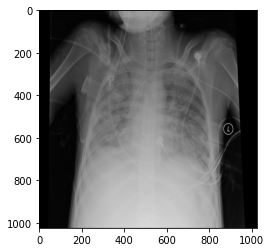

In [ ]:
print("\nAvailable meta data:")
print('-'*20 + "\n")
display(ds_list[24056])

print("\n\nActual image:")
print('-'*13 + "\n")
plt.imshow(ds_list[24056].pixel_array, cmap=plt.cm.gray)
plt.show()

In [ ]:
ds_class_info=pd.read_csv('/content/drive/MyDrive/capstone_dataset/stage_2_detailed_class_info.csv')
ds_train_labels=pd.read_csv('/content/drive/MyDrive/capstone_dataset/stage_2_train_labels.csv')

In [ ]:
#Training Dataset Labels
ds_train_labels.sample(5)

patientId      x      y  width  height  \
19853  b7609013-f48b-4b69-bb97-492aeb322e8d    NaN    NaN    NaN     NaN   
14853  91fe5edb-3ea8-4eef-8da9-ab3d665dd69d    NaN    NaN    NaN     NaN   
16880  a292caa1-4d93-4775-88f4-4b188544fb18    NaN    NaN    NaN     NaN   
24175  d9528d5b-b058-467c-accb-618c100f3696  232.0  469.0  193.0   329.0   
29841  2744f4b1-f0a3-4f65-be56-2b93eb72f56a    NaN    NaN    NaN     NaN   

       Target  
19853       0  
14853       0  
16880       0  
24175       1  
29841       0

In [ ]:
ds_class_info.sample(5)

patientId                         class
17947  aaa04d93-39da-47c1-8736-a1a2c85114af                  Lung Opacity
26363  eb5303e6-4591-4a5e-bdc0-409988dc34a5  No Lung Opacity / Not Normal
3364   37eaff2f-8993-45b8-8fb7-845e55df22e5                        Normal
25706  e5f292ae-f1e5-497c-b0a0-68f1aa2196b2  No Lung Opacity / Not Normal
1657   17c89450-d10e-4041-afa0-4c5a39adccdd                        Normal

In [ ]:
ds_class_info['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [ ]:
ds_train_labels['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [ ]:
ds_class_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
ds_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


**Only pnemoic class(1) has bounding box values which is 9555**

In [ ]:
ds_list[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3290.1517874301.323243
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3290.1517874301.323243
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

**Step 2: Map training and testing images to its classes.**

In [ ]:
ds_train_labels_merged = pd.concat([ds_train_labels,ds_class_info.drop(columns=['patientId'])], axis=1)

In [ ]:
ds_train_labels_merged.sample(10)

patientId      x      y  width  height  \
29158  0567d70b-5a94-4363-a162-7207ffaff023  685.0  630.0  134.0   140.0   
26670  ed78aad5-54e8-4853-aae8-dcb8f8dc9e79    NaN    NaN    NaN     NaN   
12534  7f957ae7-0d22-47c2-8c41-ecf5aeccb1f0  620.0  597.0  209.0   219.0   
12550  7fa60e93-a01d-4523-b164-b76cf61fb209    NaN    NaN    NaN     NaN   
5401   4698e391-5722-4947-a6f7-ff1fce632746    NaN    NaN    NaN     NaN   
3627   399ee232-f05c-4b4a-9ff4-8569eee9fe06    NaN    NaN    NaN     NaN   
9124   6506294e-f405-419d-8de1-1c70f7382a27    NaN    NaN    NaN     NaN   
10350  6e6c01ff-6fcd-4753-bec3-71116c3ecfdb    NaN    NaN    NaN     NaN   
19788  b6ec4cf8-03e9-40c7-b4de-3a123ab75a03    NaN    NaN    NaN     NaN   
25938  e7c89679-d782-405d-9974-f8f86fdd5a0c    NaN    NaN    NaN     NaN   

       Target                         class  
29158       1                  Lung Opacity  
26670       0                        Normal  
12534       1                  Lung Opacity  
12550       0                        Normal  
5401        0                        Normal  
3627        0                        Normal  
9124        0  No Lung Opacity / Not Normal  
10350       0  No Lung Opacity / Not Normal  
19788       0  No Lung Opacity / Not Normal  
25938       0  No Lung Opacity / Not Normal

In [ ]:
ds_train_labels_merged.shape

(30227, 7)

In [ ]:
# null values in x, y, width, height indicates that there is no pneumonia. Replacing null with 0
ds_train_labels_merged.fillna(0, inplace=True)
ds_train_labels_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


**Step 3**: Map training and testing images to its annotations.

In [ ]:
# We need to create a merged data set with all the parameters in one place.
parameters = ['Modality', 'Age', 'Gender', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

#get file list from folder
image_train_path = os.listdir('/content/stage_2_train_images')
image_test_path = os.listdir('/content/stage_2_test_images')

if(os.path.isfile('/content/train_labels_merged_metadata.csv')):
    ds_train_labels_merged = pd.read_csv('/content/train_labels_merged_metadata.csv')
    ds_train_labels_merged.drop([ds_train_labels_merged.columns[0]], axis=1, inplace=True)
else:
    for var in parameters:
          ds_train_labels_merged[var] = None
    #iterate on files and append metadata
    for i,filename in enumerate(image_train_path):
          dcm_data = pydicom.read_file('/content/stage_2_train_images/'+filename)
          idx = (ds_train_labels_merged['patientId']==dcm_data.PatientID)
          ds_train_labels_merged.loc[idx,'Modality'] = dcm_data.Modality
          ds_train_labels_merged.loc[idx,'Age'] = pd.to_numeric(dcm_data.PatientAge)
          ds_train_labels_merged.loc[idx,'Gender'] = dcm_data.PatientSex
          ds_train_labels_merged.loc[idx,'BodyPartExamined'] = dcm_data.BodyPartExamined
          ds_train_labels_merged.loc[idx,'ViewPosition'] = dcm_data.ViewPosition
          ds_train_labels_merged.loc[idx,'ConversionType'] = dcm_data.ConversionType
          ds_train_labels_merged.loc[idx,'Rows'] = dcm_data.Rows
          ds_train_labels_merged.loc[idx,'Columns'] = dcm_data.Columns  
          ds_train_labels_merged.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",dcm_data.PixelSpacing[0]) 
    #save to a file for future
    ds_train_labels_merged.to_csv('/content/train_labels_merged_metadata.csv')

ds_train_labels_merged['xc'] = ds_train_labels_merged['x'] + ds_train_labels_merged['width'] / 2
ds_train_labels_merged['yc'] = ds_train_labels_merged['y'] + ds_train_labels_merged['height'] / 2

ds_train_labels_merged.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality Age Gender BodyPartExamined  \
0  No Lung Opacity / Not Normal       CR  51      F            CHEST   
1  No Lung Opacity / Not Normal       CR  48      F            CHEST   
2  No Lung Opacity / Not Normal       CR  19      M            CHEST   
3                        Normal       CR  28      M            CHEST   
4                  Lung Opacity       CR  32      F            CHEST   

  ViewPosition ConversionType  Rows Columns PixelSpacing     xc     yc  
0           PA            WSD  1024    1024        0.143    0.0    0.0  
1           PA            WSD  1024    1024        0.194    0.0    0.0  
2           AP            WSD  1024    1024        0.168    0.0    0.0  
3           PA            WSD  1024    1024        0.143    0.0    0.0  
4           AP            WSD  1024    1024        0.139  370.5  341.5

In [ ]:

#--> mss/ fss: male/ female senior citizen; mped/ fped: male/female pediatric patient; madult/fadult: male/ female

from keras.engine.data_adapter import GeneratorDataAdapter
mss,mn,mped,mpreteen,mteen,madult=0,0,0,0,0,0
fss,fn,fped,fpreteen,fteen,fadult=0,0,0,0,0,0

x=ds_train_labels_merged['Age']
y=ds_train_labels_merged['Gender']

for i in range(len(ds_train_labels_merged['Gender'])):
    if y[i]=='M':
        #for j in range(len(ds_list['Age'])):
        if x[i]>18:
            madult+=1
        if x[i]<=18 :
            mteen+=1
        if x[i]<=10 :
            mped+=1
        if x[i]>80 :
            mss+=1
        
    if y[i]=='F':
        #for j in range(len(ds_train_labels_merged['Age'])):
        if x[i]>18:
            fadult+=1
        elif x[i]<=18 :
            fteen+=1
        elif x[i]<=10 :
            fped+=1
        elif x[i]>60 :
            fss+=1
        

display("Male", "adult",madult, "teen",mteen,"ped", mped, "mss", mss)
display("FeMale", fadult, "teen",fteen,"ped",fped, "fss", fss)

'Male'

'adult'

16174

'teen'

1042

'ped'

334

'mss'

148

'FeMale'

12355

'teen'

656

'ped'

0

'fss'

0

**Step 4:** Preprocessing and Visualisation of different classes [4 Point]

In [ ]:
bounding_box_count = {}
for patient in ds_train_labels.patientId:
    delme = ds_train_labels[ds_train_labels['patientId'] == patient]
    for index, row in delme.iterrows():
        stri = " ".join([str(row['x']),
                    str(row['y']), 
                    str(row['width']), 
                    str(row['height'])])
        if patient in bounding_box_count:
            bounding_box_count[patient].add(stri)
        else:
            bounding_box_count[patient] = set()
            bounding_box_count[patient].add(stri)


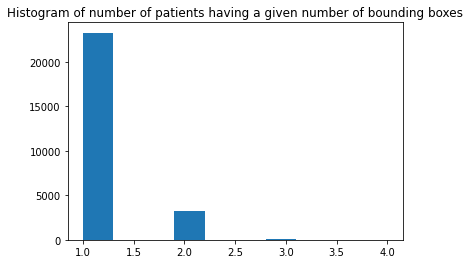

In [ ]:
bbcnt = [len(list(bounding_box_count[k])) for k in bounding_box_count]
plt.hist(bbcnt)
plt.title("Histogram of number of patients having a given number of bounding boxes")
plt.show()

In [ ]:
def preproc(fndf, tarvar):
    dupli = fndf.duplicated()
    non_duplicated_data = fndf[~dupli]
    duplicated_data = fndf[dupli]

    # checking for duplicates
    print("\nTotal Patients:", fndf['patientId'].count())
    print("Unique Patients:", fndf['patientId'].nunique())
    
    # Value counts:
    print("\n\nValue Counts in duplicated data:")
    print(fndf[tarvar].value_counts())
    ax = sns.countplot(x = tarvar, data = fndf)
    for p, label in zip(ax.patches, fndf[tarvar].value_counts().index):
        ht_label = str(round(float(p.get_height())/len(fndf)*100, 2))
        ax.annotate(ht_label + "%", (p.get_x()+0.375, p.get_height()+10))
    plt.show()

    print("\n\nValue Counts in non-duplicated data:")
    print(non_duplicated_data[tarvar].value_counts())
    ax = sns.countplot(x = tarvar, data = non_duplicated_data)
    for p, label in zip(ax.patches, non_duplicated_data[tarvar].value_counts().index):
        ht_label = str(round(float(p.get_height())/len(non_duplicated_data)*100, 2))
        ax.annotate(ht_label + "%", (p.get_x()+0.375, p.get_height()+10))
    plt.show()

    print("\n\nINFO:")
    print(fndf.info())

    print("\n\ndescribe:")
    print(fndf.describe()) 



Total Patients: 30227
Unique Patients: 26684


Value Counts in duplicated data:
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


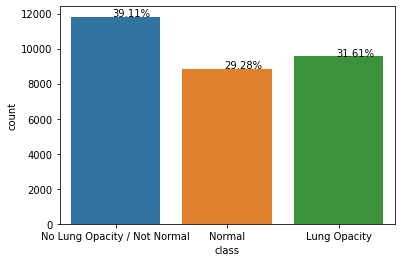



Value Counts in non-duplicated data:
No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64


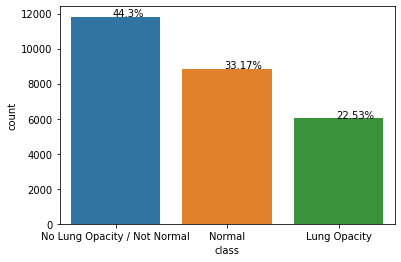



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB
None


describe:
                                   patientId                         class
count                                  30227                         30227
unique                                 26684                             3
top     3239951b-6211-4290-b237-3d9ad17176db  No Lung Opacity / Not Normal
freq                                       4                         11821


In [ ]:
preproc(ds_class_info,'class')

#### Observations:
1. There are 26,684 Images in train set
2. There are 30227 records in Class Information, and Train Labels set
3. There are 9555 records with "Lung Opacity" and correspondingly
4. There are 6021 patients with single Lung Opacity instance
5. There are 3543 patients with two Lung Opacity instance


In [ ]:
#--> printed for clarity::
display("Train Set",ds_list[0].pixel_array.shape)
display("Test Set",ds_list_test[0].pixel_array.shape)
display("Train Set", ds_list[0].pixel_array)
display("Test Set",ds_list_test[0].pixel_array)


'Train Set'

(1024, 1024)

'Test Set'

(1024, 1024)

'Train Set'

array([[  0,  10,  32, ...,  65,  60,  74],
       [  2,  20,  51, ...,  93,  91, 118],
       [  0,  18,  52, ...,  81,  83, 113],
       ...,
       [  0,  30,  91, ...,  82,  84,  90],
       [  3,  32,  78, ...,  81,  83,  85],
       [  0,   0,   2, ...,   0,   1,   1]], dtype=uint8)

'Test Set'

array([[  1,   3,   4, ...,   2,   1,   1],
       [  5,   7,   8, ...,   2,   2,   2],
       [  6,   8,  10, ...,   3,   3,   2],
       ...,
       [  5,   7,   8, ..., 126, 126,  67],
       [  5,   6,   8, ..., 126, 131,  79],
       [  2,   4,   4, ...,  58,  70,  30]], dtype=uint8)

In [ ]:
male=ds_train_labels_merged[ds_train_labels_merged['Gender']=='M']
female=ds_train_labels_merged[ds_train_labels_merged['Gender']=='F']

Gender and Classwise Age Distribution


[Text(0, 0.5, 'Female')]

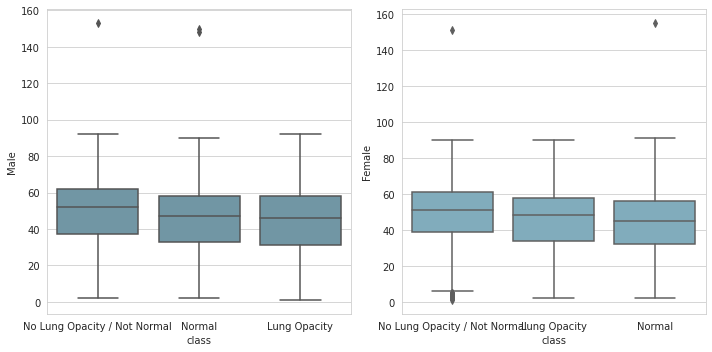

In [ ]:
print("Gender and Classwise Age Distribution")
sns.set_style("whitegrid")
c1='No Lung Opacity / Not Normal'
c2='Lung Opacity'
c3='Normal'

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)

mc1=sns.boxplot(y=male['Age'], x=male['class'], data=male.sort_values("class"), ax=ax1,color='#689aad')
mc1.set(ylabel='Male')

mc1=sns.boxplot(y=female['Age'], x=female['class'], data=female.sort_values("class"), ax=ax2,color='#77b0c6')
mc1.set(ylabel='Female')


In [ ]:
from matplotlib.patches import Rectangle

def plot_opa_dist(data,color_point, color_window,text):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    plt.title("Lung Opacity (Centre) rectangles\n{}".format(text))
    data.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color=color_point)
    for i, crt_sample in data.iterrows():
        ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
            width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color=color_window))
    plt.show()

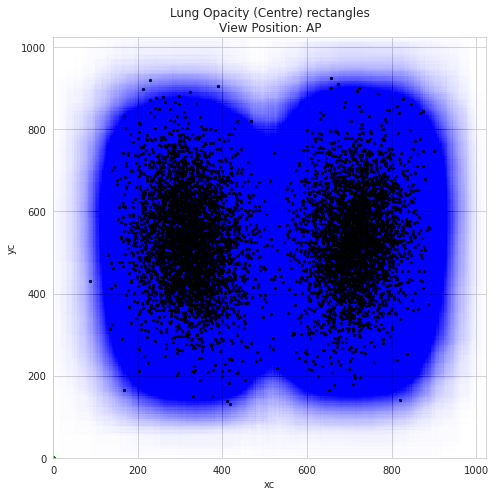

In [ ]:
position_par = (ds_train_labels_merged['ViewPosition']=='AP') 

plot_opa_dist(ds_train_labels_merged[ position_par ],'green', 'blue', 'View Position: AP')

The above plot shows Lung Opacity area (Area calculated from bounding box dimensions) over X Rays taken in "Anterior Posterior" position. 

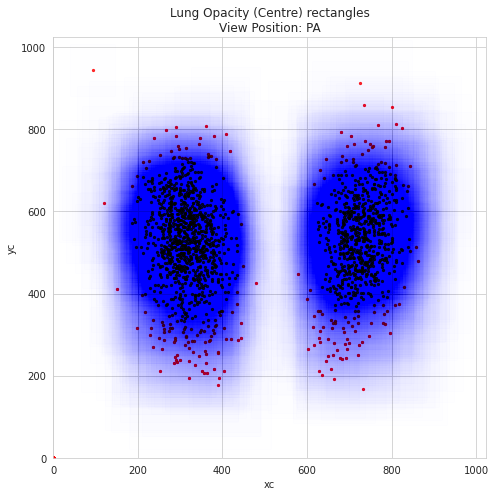

In [ ]:
position_par = (ds_train_labels_merged['ViewPosition']=='PA') 

plot_opa_dist(ds_train_labels_merged[ position_par ],'red', 'blue', 'View Position: PA')

The above plot shows Lung Opacity area over X Rays taken in "Posterior-Anterior (PA) " position.  

**Step 5: Display images with bounding box. [ 5 points ]**

In [ ]:
def plot_img_bbox(img, df, name, extra_names=""):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    a.imshow(img, cmap = 'gray')
    boxes_df = df[df['patientId']==name]

    for index, row in boxes_df.iterrows():
        x, y, width, height  = row['x'], row['y'], row['width'], row['height']
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.title(name +  " "  + extra_names)
    plt.show()

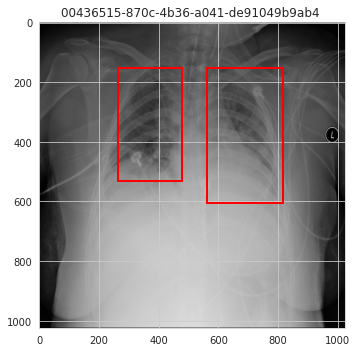

In [ ]:
lung_opacity_patient = "00436515-870c-4b36-a041-de91049b9ab4"
patient_index = ds_train_names.index(lung_opacity_patient + ".dcm")
img = ds_list[patient_index].pixel_array
plot_img_bbox(img, ds_train_labels_merged, lung_opacity_patient)

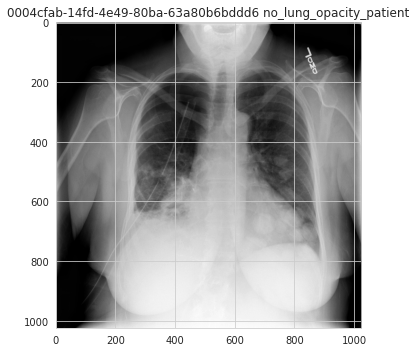

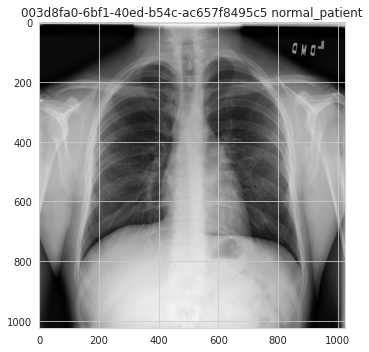

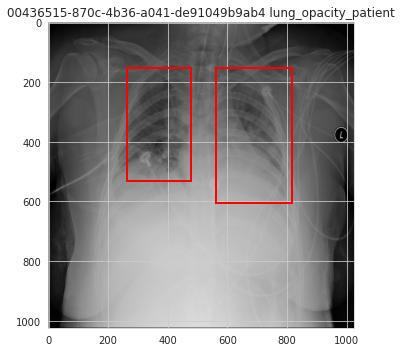

In [ ]:
no_lung_opacity_patient = "0004cfab-14fd-4e49-80ba-63a80b6bddd6"
patient_index = ds_train_names.index(no_lung_opacity_patient + ".dcm")
img = ds_list[patient_index].pixel_array
plot_img_bbox(img, ds_train_labels_merged, no_lung_opacity_patient, "no_lung_opacity_patient")

normal_patient = "003d8fa0-6bf1-40ed-b54c-ac657f8495c5"
patient_index = ds_train_names.index(normal_patient + ".dcm")
img = ds_list[patient_index].pixel_array
plot_img_bbox(img, ds_train_labels_merged, normal_patient, "normal_patient")

lung_opacity_patient = "00436515-870c-4b36-a041-de91049b9ab4"
patient_index = ds_train_names.index(lung_opacity_patient + ".dcm")
img = ds_list[patient_index].pixel_array
plot_img_bbox(img, ds_train_labels_merged, lung_opacity_patient, "lung_opacity_patient")



**Step 6: Design, train and test basic CNN models for classification.**

Split the data into train and validation set

In [ ]:
# Use part of the data for training earlier and then run for 100% of the data
import random
from skimage.transform import resize
folder = 'stage_2_train_images'
filenames = os.listdir(folder)
percentage_data_used = 50
file_count = int(len(filenames)*percentage_data_used/100)
print("Total files available:",file_count)


Total files available: 13342


In [ ]:
random.shuffle(filenames)

# split into train and validation filenames
n_valid_samples = int(file_count * 0.3)

train_filenames = filenames[n_valid_samples:file_count]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

image_dimension = 128
print('Image Dimension to use:',image_dimension)
print('sample file:',filenames[179])

n train samples 9340
n valid samples 4002
Image Dimension to use: 128
sample file: 402c68a6-62b1-4a22-8c40-631c32ac86fd.dcm


In [ ]:
# Check dist of selected files based on the csv that was provided. 
# Did not try stratified sampling since the distribution is not impacted much.
def check_distribution(dataframe_to_check):
  filename_check = pd.DataFrame(columns=['patientId','class'])
  #get filename 
  for filename in dataframe_to_check:
    filename_check = filename_check.append(ds_train_labels_merged[ds_train_labels_merged['patientId'] == filename.split('.')[0]])
    
  print('Rows',len(filename_check))
  print('unique',len(filename_check['patientId'].unique()))
  print(filename_check['class'].value_counts(normalize = True))

check_distribution(train_filenames)
check_distribution(valid_filenames)

Rows 10584
unique 9340
No Lung Opacity / Not Normal    0.395408
Lung Opacity                    0.317177
Normal                          0.287415
Name: class, dtype: float64
Rows 4504
unique 4002
No Lung Opacity / Not Normal    0.387877
Lung Opacity                    0.310835
Normal                          0.301288
Name: class, dtype: float64


In [ ]:
check_distribution(filenames)
# Overall Distribution is very similar to the distribution in train and validation data set.

Rows 30227
unique 26684
No Lung Opacity / Not Normal    0.391074
Lung Opacity                    0.316108
Normal                          0.292818
Name: class, dtype: float64


In [ ]:
# identifying if there are any files beside dcm in the folder
for name in filenames:
  le = len(name)
  if(name[le-3:le] != 'dcm'):
    print(name)

In [ ]:
! ls /content/drive/MyDrive

 CapstoneCVPnemonia
 capstone_dataset
 capstone_datasetlogs_cnn_segment.csv
 capstone_datasetpneumonia_model_2_all_data_batchof50.h5
 capstone_datasetpneumonia_model_2_all_data_batchof50_history.csv
 capstone_datasetpneumonia_model_densenet.h5
 capstone_datasetpneumonia_model_densenet_history.csv
 capstone_datasetpneumonia_model.h5
 capstone_datasetpneumonia_model_history.csv
'Colab Notebooks'
'Final submissions'


Create a dictionary of pneumonia locations in one place.

In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/capstone_dataset"
SAVE_PATH = "/content/drive/MyDrive/capstone_dataset"
TRAIN_PATH = "/content/stage_2_train_images"

In [ ]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join(PROJECT_PATH,'stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

**Generator class**

In [ ]:
import keras

# The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.
# Generator class to handle:
# Image load from folder during train and predict modes, shuffle on epoc end, 
# resize loaded images, augment if needed, add trailing channel dimension
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=image_dimension, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    # Loads the file from folder, resizes and augments the data with horizontal flip    
    def __load__(self, filename):
        # load dicom file as numpy array
        #print('reading file:', filename)
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array

        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect')
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    # Loads images during prediction cycles
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        # print('reading file:', filename)
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array
        
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    # Generator must implement this getter function    
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks

    # Shuffle data before start of next epoc    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def set_and_train_model(batch_size, train_filenames, valid_filenames, epochs):

    print('STARTING TRAINING\n\n')
    print(f"SETTINGS: \nbatch_size: {batch_size}\ntrain_filenames:{len(train_filenames)}")
    print(f"valid_filenames:{len(valid_filenames)}\nepochs:{epochs}\n\n")

    # create 1 downsample layer, each containing 4 layers in it
    def create_downsample(channels, inputs):
        x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
        x = keras.layers.MaxPool2D(2)(x)
        return x

    # creates 1 residual layer, each containing 6 layers in it.
    def create_resblock(channels, inputs):
        x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
        return keras.layers.add([x, inputs])

    # Model creator
    # Depth = number of layers in the model
    def create_network(input_size, channels, n_blocks=2, depth=4):
        # input layers - 2 layer
        inputs = keras.Input(shape=(input_size, input_size, 1))
        x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
        # residual blocks (4*4 downsample + 4*2*6 resblock = 64 layers)
        for d in range(depth):
            channels = channels * 2
            x = create_downsample(channels, x)
            for b in range(n_blocks):
                x = create_resblock(channels, x)
        # output - 4 layers
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
        outputs = keras.layers.UpSampling2D(2**depth)(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        return model


    # define iou or jaccard loss function
    def iou_loss(y_true, y_pred):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true * y_pred)
        score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
        return 1 - score

    # combine bce loss and iou loss
    def iou_bce_loss(y_true, y_pred):
        return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

    # mean iou as a metric
    def mean_iou(y_true, y_pred):
        y_pred = tf.round(y_pred)
        intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
        smooth = tf.ones(tf.shape(intersect))
        return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

    # create network and compiler
    model = create_network(input_size=image_dimension, channels=32, n_blocks=2, depth=2)
    model.compile(optimizer='adam',
                  loss=iou_bce_loss,
                  metrics=['accuracy', mean_iou, f1_m, precision_m, recall_m])


    print("\nMODEL SUMMARY:\n")
    print(model.summary())

    # cosine learning rate annealing
    # changes learning rate based on the number of epocs passed
    def cosine_annealing(x):
        lr = 0.001
        epochs = 25
        return lr* (np.cos(np.pi*x/epochs)+1.) /2
    learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

    # keeps logging the epoc output simultaneously while training
    csv_logger = tf.keras.callbacks.CSVLogger(SAVE_PATH + 'logs_cnn_segment.csv', append = True)

    # Creating checkpoint of the best model to avoid save errors later on.
    # Saves training time once the best model is achieved.
    cp = tf.keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH + 'model_checkpoint.h5', verbose = 1, save_best_only = True)

    # Keep monitoring val_loss to see if there is any improvement. 
    # Mostly the model kept loss in a range so keeping patience as 4 to avoid bloating training time. 
    # Any improvement of 0.5% in val_loss would get captured
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=4, restore_best_weights=True, verbose=1, mode='auto')



    # create train and validation generators
    train_gen = generator(TRAIN_PATH, train_filenames, pneumonia_locations, batch_size=batch_size, image_size=image_dimension, shuffle=False, augment=False, predict=False)
    valid_gen = generator(TRAIN_PATH, valid_filenames, pneumonia_locations, batch_size=batch_size, image_size=image_dimension, shuffle=False, predict=False)
     
    print("\n\nMODEL TRAINING:\n")
    history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate,csv_logger,early_stopping], 
                                  epochs=epochs, workers=4, use_multiprocessing=True)

    # Save Model and history
    training_mode = True
    if(training_mode):
      export_file_path = SAVE_PATH+'pneumonia_model.h5'

      # Save the model
      model.save(export_file_path)
      print('model saved\n')

      # Save history file
      print(history.history.keys())
      # convert the history.history dict to a pandas DataFrame:     
      hist_df = pd.DataFrame(history.history) 

      # or save to csv: 
      hist_csv_file = SAVE_PATH+'pneumonia_model_history.csv'
      with open(hist_csv_file, mode='w') as f:
          hist_df.to_csv(f)
      print('history saved\n')

      
    else:
      model.load_weights(SAVE_PATH+'pneumonia_model.h5')
      history = pd.read_csv(SAVE_PATH+'pneumonia_model_history.csv')
      history


    ## Accuracy and Loss plots

    print("\n\n PLOTTING TRAINING RESULTS \n")

    accuracy      = history.history['accuracy']
    val_accuracy  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs   = range(len(accuracy)) # Get number of epochs

    plt.plot  (epochs, accuracy, label = 'training accuracy')
    plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
    plt.title ('Training and validation accuracy')
    plt.legend(loc = 'lower right')
    plt.figure()

    plt.plot  (epochs, loss, label = 'training loss')
    plt.plot  (epochs, val_loss, label = 'validation loss')
    plt.legend(loc = 'upper right')
    plt.title ('Training and validation loss')

    plt.show()

    # load and shuffle filenames
    folder = '/content/stage_2_test_images'
    test_filenames = os.listdir(folder)[:50]
    print("\n\n PREDICTING TEST SET:\n")
    print('n test samples:', len(test_filenames))

    model.load_weights(SAVE_PATH+'pneumonia_model.h5')

    # fn = list(set(ds_train_labels_merged[ds_train_labels_merged['class'] == 'Lung Opacity']['patientId']))[0:100]
    # folder = '/content/stage_2_train_images'
    # test_filenames = [i + ".dcm" for i in fn]
    # create test generator with predict flag set to True
    test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=128, shuffle=False, predict=True)

    print("\n\n SUBMISSION DICT : ")
    # create submission dictionary
    submission_dict = {}
    # loop through testset
    for imgs, filenames in test_gen:
        # predict batch of images
        preds = model.predict(imgs)
        # loop through batch
        for pred, filename in zip(preds, filenames):
            # resize predicted mask
            pred = resize(pred, (1024, 1024), mode='reflect')
            # threshold predicted mask
            comp = pred[:, :, 0] > 0.5
            # apply connected components
            comp = measure.label(comp)
            # apply bounding boxes
            predictionString = ''
            for region in measure.regionprops(comp):
                # retrieve x, y, height and width
                y, x, y2, x2 = region.bbox
                height = y2 - y
                width = x2 - x
                # proxy for confidence score
                conf = np.mean(pred[y:y+height, x:x+width])
                # add to predictionString
                predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
            # add filename and predictionString to dictionary
            filename = filename.split('.')[0]
            submission_dict[filename] = predictionString
        # stop if we've got them all
        if len(submission_dict) >= len(test_filenames):
            break

    return submission_dict


STARTING TRAINING


SETTINGS: 
batch_size: 100
train_filenames:800
valid_filenames:100
epochs:5



MODEL SUMMARY:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0

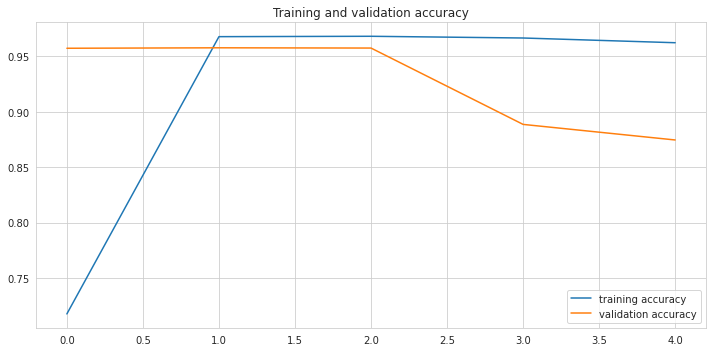

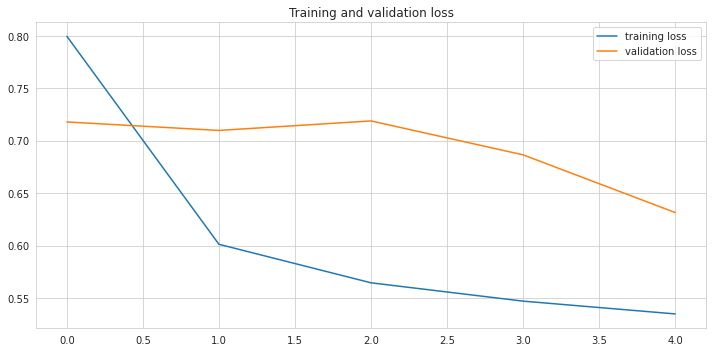



 PREDICTING TEST SET:

n test samples: 50


 SUBMISSION DICT : 
1/1 [==============================] - 0s 31ms/step


{'2ab7d4ea-97dd-4bb4-a803-6d39ea8d6be2': '0.5041763 386 130 34 30 0.5129824 514 160 414 508 0.54186386 227 254 254 515 0.50854826 128 322 66 62 0.50843334 929 481 61 95 0.52100056 864 542 64 163 ',
 '270e6509-5f4c-448d-bb55-822343311cb8': '0.5312807 673 416 125 190 0.49527714 801 672 59 61 ',
 '2a27aad6-fdc7-491f-885d-44d5619a6cf5': '0.50662243 227 36 32 27 0.5045154 163 67 59 26 0.5546615 194 131 254 569 0.50081015 546 131 124 96 0.505443 862 132 63 62 0.4963709 98 161 91 92 0.53321487 574 254 254 672 ',
 '30384474-2ef9-4cd9-813f-4c5559c18e1a': '0.5022675 707 36 26 25 0.50196934 771 68 26 29 0.51007557 671 97 32 30 0.52572095 125 99 354 609 0.4554978 736 126 222 324 0.53070515 605 481 191 320 ',
 '274def79-ae29-4b96-a222-4489e79d54ea': '0.52877533 195 164 225 476 0.522034 610 195 187 156 ',
 '22c2a3d1-252f-42bf-bf1c-f51427ab5640': '0.53675216 860 258 70 287 0.53333956 192 259 221 380 0.5152175 580 381 217 323 ',
 '19d85ca1-c8e8-4638-943c-321b5116b01c': '0.5105049 514 125 123 70 0.4833

In [ ]:
set_and_train_model(batch_size=100, train_filenames=train_filenames[:800], valid_filenames=valid_filenames[:100], epochs=5)


**With all files in current sampled training set:**

Listing out:
1. training results
2. Plotting training results
3. Predicting test data
4. Visualising a few validation results


STARTING TRAINING


SETTINGS: 
batch_size: 50
train_filenames:9340
valid_filenames:4002
epochs:5



MODEL SUMMARY:

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 32  288         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 128, 128, 32  128        ['conv2d_1

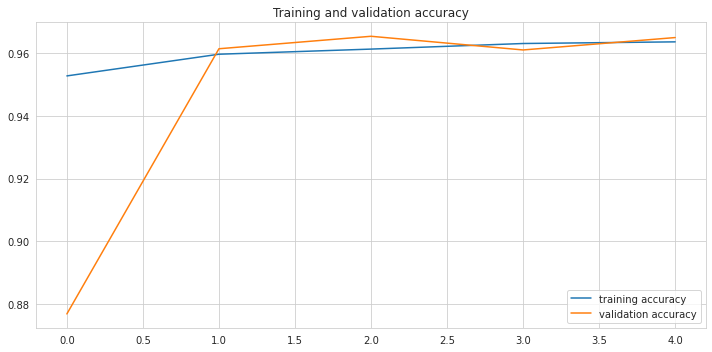

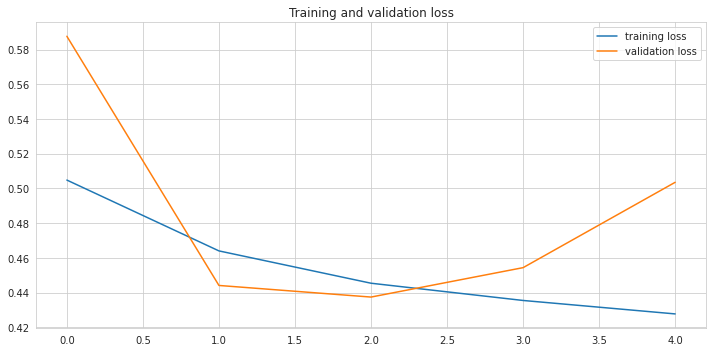



 PREDICTING TEST SET:

n test samples: 50


 SUBMISSION DICT : 
1/1 [==============================] - 0s 20ms/step


{'2ab7d4ea-97dd-4bb4-a803-6d39ea8d6be2': '',
 '270e6509-5f4c-448d-bb55-822343311cb8': '',
 '2a27aad6-fdc7-491f-885d-44d5619a6cf5': '',
 '30384474-2ef9-4cd9-813f-4c5559c18e1a': '',
 '274def79-ae29-4b96-a222-4489e79d54ea': '0.6197831 382 288 95 227 ',
 '22c2a3d1-252f-42bf-bf1c-f51427ab5640': '',
 '19d85ca1-c8e8-4638-943c-321b5116b01c': '',
 '1d3e1e8b-f6d0-4289-b5e1-c9e992ee1225': '0.5371662 419 220 92 385 ',
 '272c0574-55f6-48c3-a450-a794a1328510': '',
 '26aff0c5-644d-4bde-9716-3b7605496da4': '',
 '14b51a44-118d-42ac-91f8-f072f3eacc7b': '',
 '2e194355-bbe5-4755-a828-bf4e3710d5de': '',
 '13951087-5cda-44c7-9624-037c3ae8404f': '0.5541998 450 383 28 66 ',
 '03d837fb-4528-4e56-bf4e-58fbeae187bb': '0.64532864 125 323 288 479 0.6168155 706 452 93 94 ',
 '1e73cb06-5a8d-4246-a349-2912217ba152': '',
 '01972669-8b42-4b47-96ac-e6a085e504ba': '0.5516603 320 545 92 160 0.588575 224 676 32 62 ',
 '1aa20b52-2de4-4e86-a724-81c777afe247': '0.5934477 894 452 33 94 ',
 '2bd29296-2fa9-4708-bea7-2a3ea286723d

In [ ]:
set_and_train_model(batch_size=50, train_filenames=train_filenames, valid_filenames=valid_filenames, epochs=5)

**Observations from the training**


*  The Loss plot and the accuracy plot show that with the larger dataset, we might need a large batch size as well to have consistent improvement and reach a local minima.We currently can't do that because of shortage of RAM we bought in googlecolab.
*  The submission sample is looking good however - we are able to predict bounding boxes in some test samples. 
* There are a few samples that have 0, 1 or 2 bounding boxes. 
* There are a few samples that have 3 bounding boxes too. The accuracy of this will be revisited in milestone 2. 



In [ ]:
# create 1 downsample layer, each containing 4 layers in it
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

# creates 1 residual layer, each containing 6 layers in it.
def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

# Model creator
# Depth = number of layers in the model
def create_network(input_size, channels, n_blocks=2, depth=4):
    # input layers - 2 layer
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks (4*4 downsample + 4*2*6 resblock = 64 layers)
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output - 4 layers
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=image_dimension, channels=32, n_blocks=2, depth=2)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

1/1 [==============================] - 0s 248ms/step


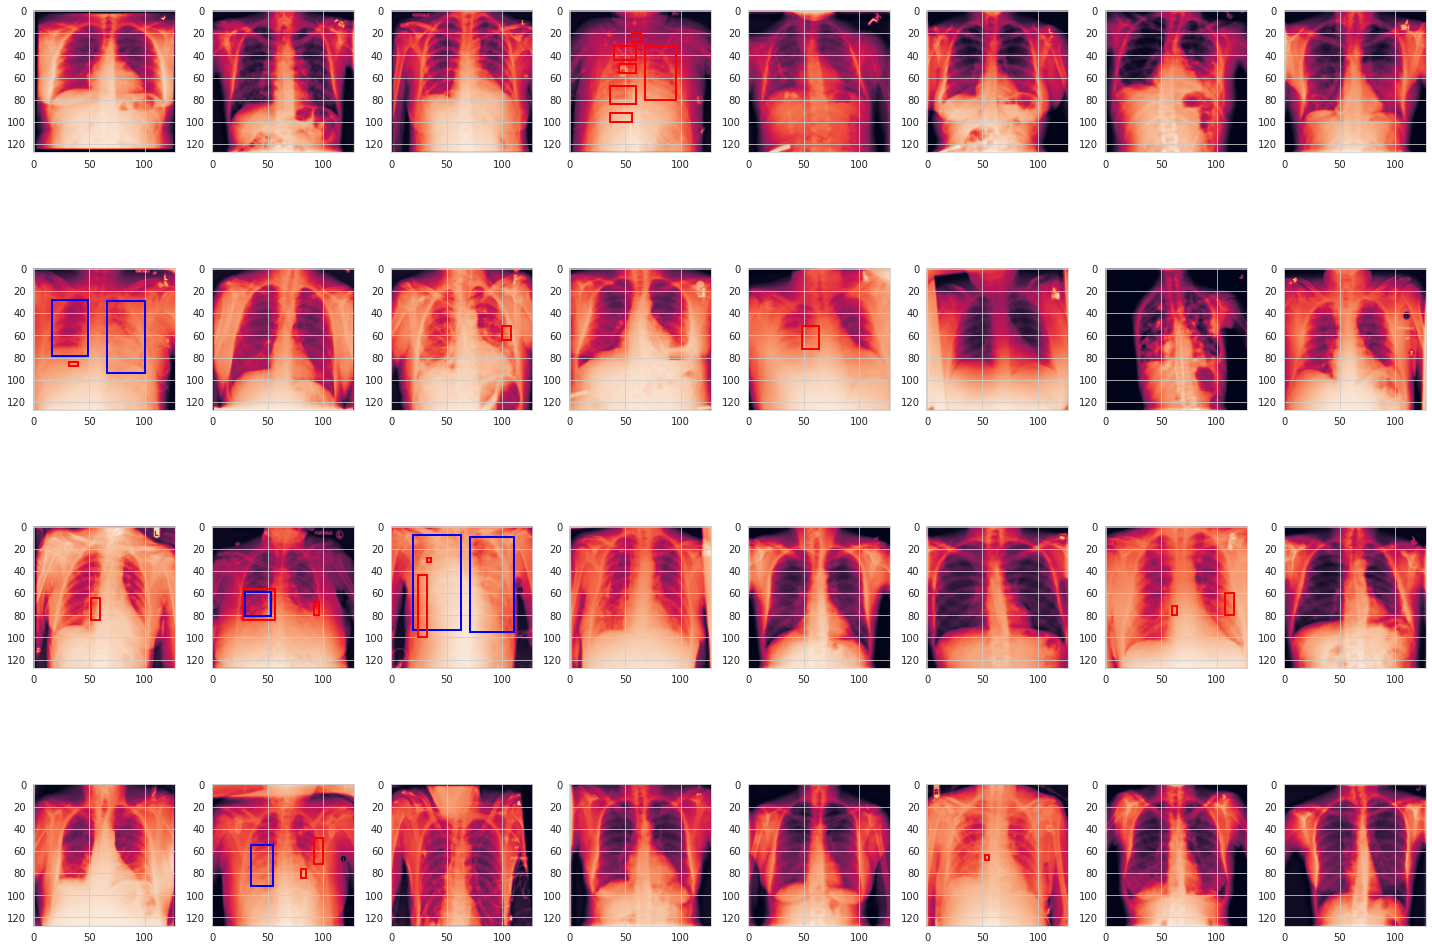

In [ ]:
# Red is predicted mask, Blue is actual Mask
model.load_weights(SAVE_PATH+'pneumonia_model.h5')

valid_gen = generator(TRAIN_PATH, valid_filenames, pneumonia_locations, batch_size=32, image_size=128, shuffle=False, predict=False)

for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))

    # Flatten the array
    axarr = axarr.ravel()
    axidx = 0

    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
        if axidx == 32:
          break
    plt.show()
    # only plot one batch
    break

# There was considerable IOU for the images where prediction was correct. 

**Visualising some of the validation set**


*  The Red is predicted mask, Blue is actual Mask.
*  There are patients for whom the predicted mask and actual mask are pretty overlapping. 
* There are a few false positives observed as well.
* These are certain areas we want to address as part of milestone 2


# Milestone 2

### Step 1: Fine tune the trained basic CNN models for classification. 

In [ ]:
def build_tuned_model_and_train(batch_size, train_filenames, valid_filenames, epochs, n_channels, n_layers, hp_learning_rate):

    print('STARTING TRAINING\n\n')
    print(f"SETTINGS: \nbatch_size: {batch_size}\ntrain_filenames:{len(train_filenames)}")
    print(f"valid_filenames:{len(valid_filenames)}\nepochs:{epochs}\n\n")

    # create 1 downsample layer, each containing 4 layers in it
    def create_downsample(channels, inputs):
        x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
        x = keras.layers.MaxPool2D(2)(x)
        return x

    # creates 1 residual layer, each containing 6 layers in it.
    def create_resblock(channels, inputs):
        x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
        return keras.layers.add([x, inputs])

    # Model creator
    # Depth = number of layers in the model
    def create_network(input_size, channels, n_blocks=2, depth = 4):
        # input layers - 2 layer
        inputs = keras.Input(shape=(input_size, input_size, 1))
        x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
        # residual blocks (4*4 downsample + 4*2*6 resblock = 64 layers)
        for d in range(depth):
            channels = channels * 2
            x = create_downsample(channels, x)
            for b in range(n_blocks):
                x = create_resblock(channels, x)
        # output - 4 layers
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
        outputs = keras.layers.UpSampling2D(2**depth)(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        return model


    # define iou or jaccard loss function
    def iou_loss(y_true, y_pred):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true * y_pred)
        score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
        return 1 - score

    # combine bce loss and iou loss
    def iou_bce_loss(y_true, y_pred):
        return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

    # mean iou as a metric
    def mean_iou(y_true, y_pred):
        y_pred = tf.round(y_pred)
        intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
        smooth = tf.ones(tf.shape(intersect))
        return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

    # create network and compiler
    tuned_model = create_network(input_size=image_dimension, channels=n_channels, n_blocks=2, depth=n_layers)
    tuned_model.compile(optimizer='adam',
                  loss=iou_bce_loss,
                  metrics=['accuracy', mean_iou, f1_m, precision_m, recall_m])


    print("\nMODEL SUMMARY:\n")
    print(tuned_model.summary())

    # cosine learning rate annealing
    # changes learning rate based on the number of epocs passed
    def cosine_annealing(x):
        lr = hp_learning_rate
        epochs = 25
        return lr* (np.cos(np.pi*x/epochs)+1.) /2
    learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

    # keeps logging the epoc output simultaneously while training
    csv_logger = tf.keras.callbacks.CSVLogger(SAVE_PATH + 'logs_cnn_segment.csv', append = True)

    # Creating checkpoint of the best model to avoid save errors later on.
    # Saves training time once the best model is achieved.
    cp = tf.keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH + 'model_checkpoint.h5', verbose = 1, save_best_only = True)

    # Keep monitoring val_loss to see if there is any improvement. 
    # Mostly the model kept loss in a range so keeping patience as 4 to avoid bloating training time. 
    # Any improvement of 0.5% in val_loss would get captured
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=4, restore_best_weights=True, verbose=1, mode='auto')



    # create train and validation generators
    train_gen = generator(TRAIN_PATH, train_filenames, pneumonia_locations, batch_size=batch_size, image_size=image_dimension, shuffle=False, augment=False, predict=False)
    valid_gen = generator(TRAIN_PATH, valid_filenames, pneumonia_locations, batch_size=batch_size, image_size=image_dimension, shuffle=False, predict=False)
     
    print("\n\nMODEL TRAINING:\n")
    history = tuned_model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate,csv_logger,early_stopping], 
                                  epochs=epochs, workers=4, use_multiprocessing=True)
    
     # Save Model and history
    training_mode = True
    if(training_mode):
      export_file_path = SAVE_PATH+'pneumonia_tuned_model.h5'

      # Save the model
      tuned_model.save(export_file_path)
      print('model saved\n')

      # Save history file
      print(history.history.keys())
      # convert the history.history dict to a pandas DataFrame:     
      hist_df = pd.DataFrame(history.history) 

      # or save to csv: 
      hist_csv_file = SAVE_PATH+'pneumonia_tuned_model_history.csv'
      with open(hist_csv_file, mode='w') as f:
          hist_df.to_csv(f)
      print('history saved\n')

      
    else:
      tuned_model.load_weights(SAVE_PATH+'pneumonia_tuned_model.h5')
      history = pd.read_csv(SAVE_PATH+'pneumonia_tuned_model_history.csv')
      history
    
     ## Accuracy and Loss plots

    print("\n\n PLOTTING TRAINING RESULTS \n")

    accuracy      = history.history['accuracy']
    val_accuracy  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs   = range(len(accuracy)) # Get number of epochs

    plt.plot  (epochs, accuracy, label = 'training accuracy')
    plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
    plt.title ('Training and validation accuracy')
    plt.legend(loc = 'lower right')
    plt.figure()

    plt.plot  (epochs, loss, label = 'training loss')
    plt.plot  (epochs, val_loss, label = 'validation loss')
    plt.legend(loc = 'upper right')
    plt.title ('Training and validation loss')

    plt.show()

    valid_gen = generator(TRAIN_PATH, valid_filenames, pneumonia_locations, batch_size=32, image_size=128, shuffle=False, predict=False)

    for imgs, msks in valid_gen:
        # predict batch of images
        preds = tuned_model.predict(imgs)
        # create figure
        f, axarr = plt.subplots(4, 8, figsize=(20,15))

        # Flatten the array
        axarr = axarr.ravel()
        axidx = 0

        # loop through batch
        for img, msk, pred in zip(imgs, msks, preds):
            # plot image
            axarr[axidx].imshow(img[:, :, 0])
            
            # threshold true mask
            comp = msk[:, :, 0] > 0.5
            # apply connected components
            comp = measure.label(comp)
            # apply bounding boxes
            predictionString = ''
            for region in measure.regionprops(comp):
                # retrieve x, y, height and width
                y, x, y2, x2 = region.bbox
                height = y2 - y
                width = x2 - x
                axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
            
            # threshold predicted mask
            comp = pred[:, :, 0] > 0.5
            # apply connected components
            comp = measure.label(comp)
            # apply bounding boxes
            predictionString = ''
            for region in measure.regionprops(comp):
                # retrieve x, y, height and width
                y, x, y2, x2 = region.bbox
                height = y2 - y
                width = x2 - x
                axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
            axidx += 1
            if axidx == 32:
              break
        plt.show()
        # only plot one batch
        break

In [ ]:
## FUnction to create a dataframe for results
def createResultDf(name,val_loss,val_accuracy):
    result = pd.DataFrame({'Method':[name], 'loss': [val_loss] ,'Validation_accuracy':[val_accuracy]})
    return result

STARTING TRAINING


SETTINGS: 
batch_size: 50
train_filenames:9340
valid_filenames:4002
epochs:10



MODEL SUMMARY:

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 128, 128, 32  288         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 128, 128, 32  128        ['conv2d_

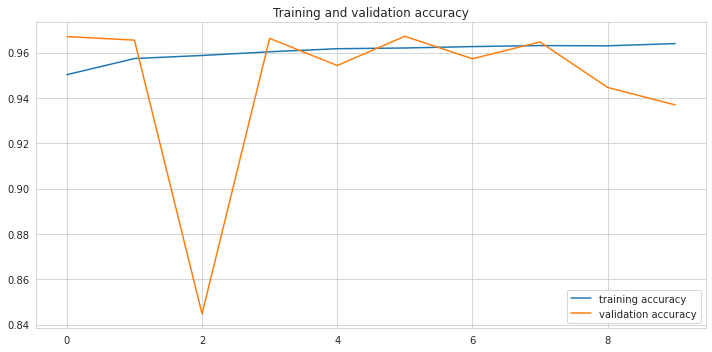

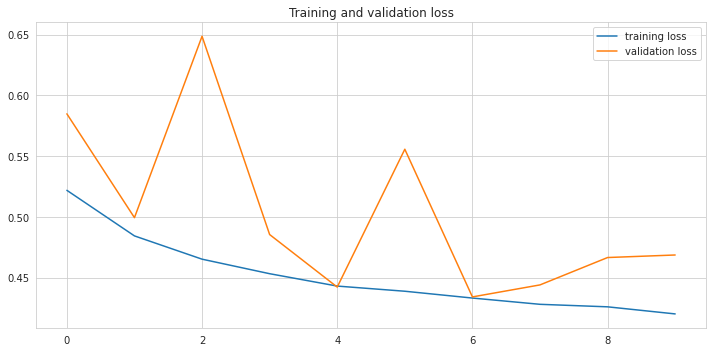

1/1 [==============================] - 0s 183ms/step


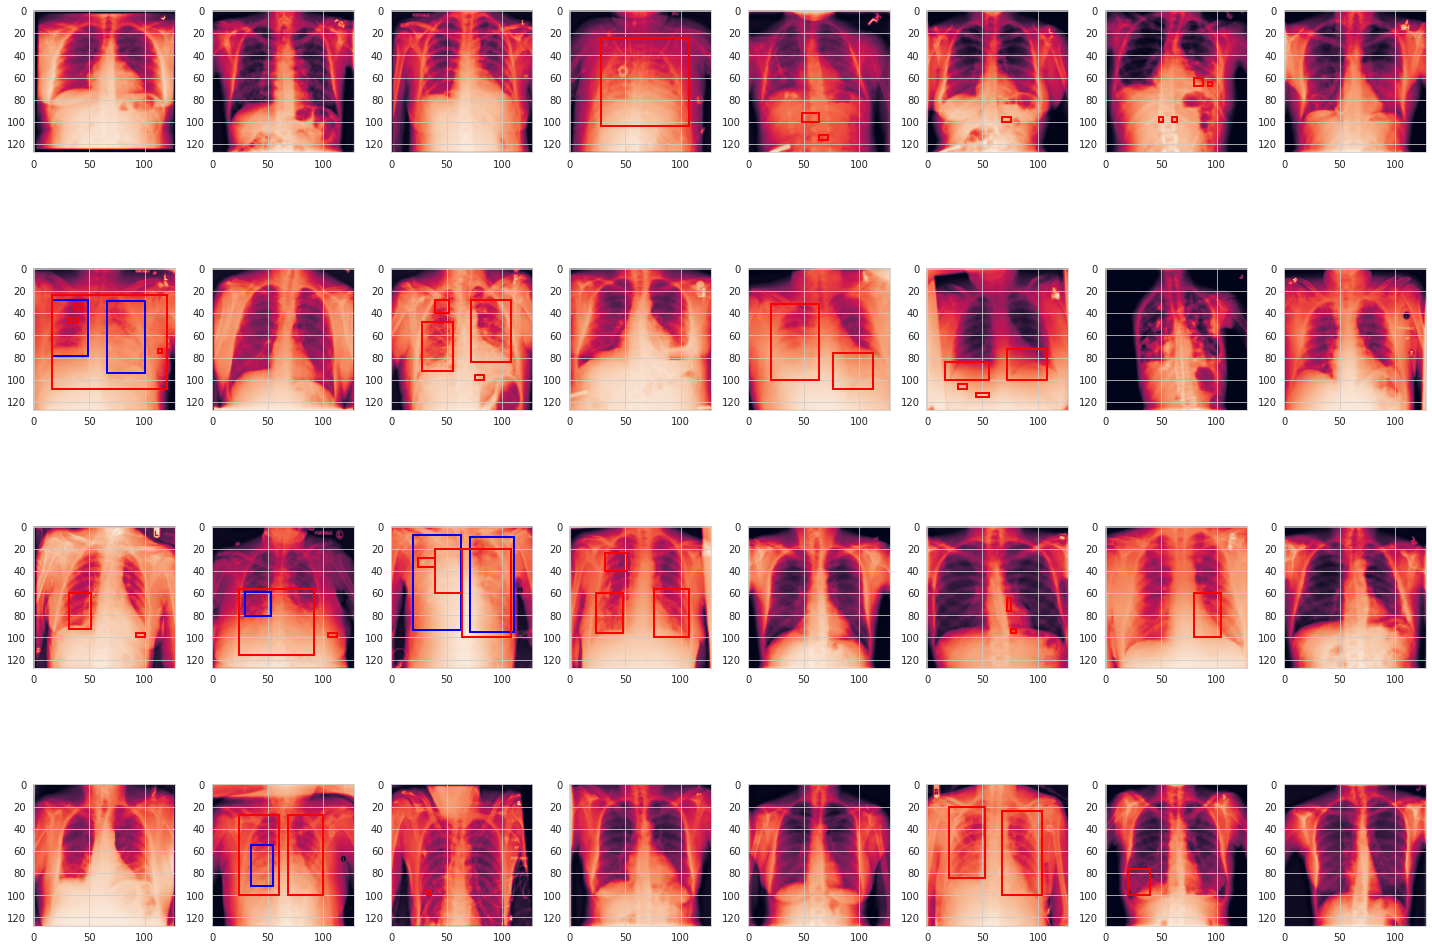

In [ ]:
build_tuned_model_and_train(batch_size=50, train_filenames=train_filenames, valid_filenames=valid_filenames, epochs=10,n_channels=32,n_layers=2,hp_learning_rate=1e-2)

In [ ]:
tuned_model.evaluate(X_test, y_test, verbose=1)

In [ ]:
resultDF = createResultDf("CNN-fineTuned",val_loss,val_accuracy)

Observations<br/>
<ul>
    <li>The hyperparameter tuning was done by tuning learning rate, epochs, layers, dropout, random sampling</li>
    <li>Increasing learning rate and epochs improved the performance a little bit</li>
    <li>The learning rate was increased from 1e-3 to 1e-2. Epochs was increased from 5 to 10</li>
    <li>The loss got reduced from 0.5 to 0.46 and f1-score increased from 0.26 to 0.38</li>
    <li>The model is already complex and tuned. We can improve further only through transfer learning</li>
</ul>

### Step 2: Apply Transfer Learning model for classification 

# Transfer Learning

In [ ]:
!pip install segmentation_models_3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.5 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import tensorflow as tf 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import pandas as pd 
import os
import pydicom
from keras.preprocessing import image
from matplotlib.pyplot import imread
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.spatial import distance
import segmentation_models_3D as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score , auc 
from keras.utils.np_utils import to_categorical   
import cv2
import gc
from keras.metrics import MeanIoU
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2 , VGG16 , ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from keras.metrics import MeanIoU
from PIL import Image
from datetime import date
AUTOTUNE = tf.data.AUTOTUNE

from sklearn.preprocessing import LabelEncoder
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam


Segmentation Models: using `tf.keras` framework.


In [ ]:
## Pre Processing the image

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = pydicom.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [ ]:
images,labels = populateImage(ds_train_labels_merged[:8000])

In [ ]:
print("Image size is:",images.shape)
print("Label size is:", labels.shape)

Image size is: (8000, 128, 128, 3)
Label size is: (8000,)


In [ ]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [ ]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [ ]:
## Creating a Copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

### Step  3:  Design,  train  and  test  RCNN  &  its  hybrids  based  object  detection  models  to  impose  the  bounding  box  or mask over the area of interest. 

# Apply Transfer Learning based on VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
## Adding two hidden later and one softmax layer as an output layer
from tensorflow.keras import layers, models


cnn_VGG16_model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(3,activation="softmax")
    ])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics= [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ],
)

## Early stopping whe validation accuracy does not change for 7 iteration 
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=7,  restore_best_weights=True)

#Trainign the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=10, validation_data=(train_val_df,y_val) ,callbacks=es)

Epoch 1/10
175/175 [==============================] - 23s 71ms/step - loss: 0.6622 - accuracy: 0.5293 - precision: 0.5485 - recall: 0.4845 - val_loss: 0.5002 - val_accuracy: 0.6425 - val_precision: 0.6561 - val_recall: 0.6058
Epoch 2/10
175/175 [==============================] - 11s 61ms/step - loss: 0.5438 - accuracy: 0.5929 - precision: 0.6183 - recall: 0.5502 - val_loss: 0.4701 - val_accuracy: 0.6458 - val_precision: 0.6560 - val_recall: 0.6150
Epoch 3/10
175/175 [==============================] - 11s 63ms/step - loss: 0.5151 - accuracy: 0.6154 - precision: 0.6376 - recall: 0.5743 - val_loss: 0.4690 - val_accuracy: 0.6567 - val_precision: 0.6741 - val_recall: 0.6308
Epoch 4/10
175/175 [==============================] - 11s 63ms/step - loss: 0.4966 - accuracy: 0.6248 - precision: 0.6429 - recall: 0.5854 - val_loss: 0.4643 - val_accuracy: 0.6392 - val_precision: 0.6607 - val_recall: 0.6183
Epoch 5/10
175/175 [==============================] - 11s 64ms/step - loss: 0.4859 - accuracy: 0

Text(0.5, 1.0, 'Accuracy Evolution')

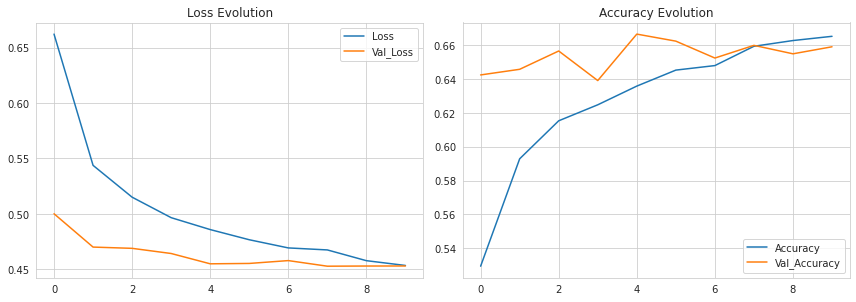

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('VGG16 Test loss:', fcl_loss)
print('VGG16 Test accuracy:', fcl_accuracy)

## The Test accuracy score if 69% but the training accurayc is 100 , this model is overfit

38/38 [==============================] - 0s 12ms/step - loss: 0.4647 - accuracy: 0.6542
VGG16 Test loss: 0.4647245407104492
VGG16 Test accuracy: 0.6541666388511658


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
pred_train = cnn_VGG16_model.predict(X_train1)
pred_train = np.argmax(pred_train,axis = 1) 
y_true_train = np.argmax(y_train,axis = 1)

175/175 [==============================] - 10s 56ms/step


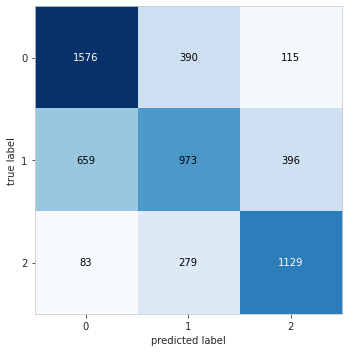

In [ ]:
CM = confusion_matrix(y_true_train, pred_train)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
pd.DataFrame(classification_report(y_true_train, pred_train, output_dict=True))

0            1            2  accuracy    macro avg  \
precision     0.679896     0.592570     0.688415  0.656786     0.653627   
recall        0.757328     0.479783     0.757210  0.656786     0.664774   
f1-score      0.716526     0.530245     0.721175  0.656786     0.655982   
support    2081.000000  2028.000000  1491.000000  0.656786  5600.000000   

           weighted avg  
precision      0.650540  
recall         0.656786  
f1-score       0.650304  
support     5600.000000

**Transfer Learing**

In [ ]:
labels=pd.read_csv('/content/drive/MyDrive/capstone_dataset/stage_2_train_labels.csv')
details = pd.read_csv('/content/drive/MyDrive/capstone_dataset/stage_2_detailed_class_info.csv')

In [ ]:
# Merging two dataframes
labels_w_class = pd.concat([labels,details.drop(columns=['patientId'])], axis=1)
labels_w_class.shape

(30227, 7)

In [ ]:
labels_w_class.head(10)

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0   
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0   
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1   
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  
5                  Lung Opacity  
6  No Lung Opacity / Not Normal  
7  No Lung Opacity / Not Normal  
8                  Lung Opacity  
9                  Lung Opacity

In [ ]:
# null values in x, y, width, height indicates that there is no pneumonia. Replacing null with 0
labels_w_class.fillna(0, inplace=True)
labels_w_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
# Checking the distribution
labels_w_class['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [ ]:
df = labels_w_class.copy()

**Taking small subset to save time and unavailability of computation unit**

In [ ]:
df_subset = labels_w_class.head(8000)
df_subset.shape

(8000, 7)

In [ ]:
df_subset.head(5)

In [ ]:
# train test split of the dataset
class_train, class_val = train_test_split(df_subset, test_size=0.20, random_state=42, stratify=df_subset['class'])

In [ ]:
# Reducing the image size from  1024 to 128

IMAGE_SIZE = 1024
ADJUSTED_IMAGE_SIZE=128
FACTOR = ADJUSTED_IMAGE_SIZE/IMAGE_SIZE

**Creating Mask, attaching bounding info with images, reducing the size of each images and convering dicom to rgb**

In [ ]:
X_feature_tr = []
y_feature_target_tr = []
y_feature_coordinates_tr = []
from PIL import Image
train_images_dir = '/content/stage_2_train_images/'
def create_mask(datafm , n_classes = 2 ):
    X = []
    y=[]
    masks = np.zeros((int(datafm.shape[0]), ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE)) #MASK_IMAGE_SIZE -> ADJUSTED_IMAGE_SIZE 
    for index, patient_id in enumerate(datafm['patientId'].T.to_dict().values()):
        image_path = train_images_dir[:8000]+patient_id+".dcm"
        img = pydicom.dcmread(image_path)
        img = img.pixel_array
        img = cv2.resize(img, (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = preprocess_input(np.array(img, dtype=np.float32))
        X.append(img)
        rows = labels_w_class[labels_w_class['patientId']==patient_id]
        y.append(rows['Target'].values[0])

        row_data = list(rows.T.to_dict().values())
        for row in row_data:
            x1 = int(row['x']*FACTOR)
            x2 = int((row['x']*FACTOR)+(row['width']*FACTOR))
            y1 = int(row['y']*FACTOR)
            y2 = int((row['y']*FACTOR)+(row['height']*FACTOR))
            masks[index][y1:y2, x1:x2] = 1
  
    del img,row,row_data
    gc.collect()
    X= np.array(X)
    y= np.array(y)
    
    train_masks_input = np.expand_dims(masks, axis=3)
    train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
    y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))

    return X, y, y_train_cat, masks

In [ ]:
class_train, class_val = train_test_split(df_subset, test_size=0.20, random_state=42, stratify=df_subset['class'])

In [ ]:
class_train.head()

patientId      x      y  width  height  \
2037  22fdcdc2-9d80-472e-b3b2-f5385004c16e    0.0    0.0    0.0     0.0   
3290  3768dc07-b49f-4e4d-8233-5dda9692ca68  190.0  488.0  251.0   209.0   
4195  3d3ff5b0-9aed-4237-a815-d1c192d7f09c    0.0    0.0    0.0     0.0   
7898  5aeb9a45-0897-43db-bceb-fa36b87c4a3a    0.0    0.0    0.0     0.0   
3633  39a5e461-791e-45f0-a4a9-2f4d06c8eca8  552.0  147.0  236.0   263.0   

      Target         class  
2037       0        Normal  
3290       1  Lung Opacity  
4195       0        Normal  
7898       0        Normal  
3633       1  Lung Opacity

In [ ]:
class_val.head()

patientId      x      y  width  height  \
2038  230adb79-3015-4657-86d3-fa3f146a10f5    0.0    0.0    0.0     0.0   
2347  31692137-f770-4cfe-a02e-fd207ce813ac  180.0  402.0  213.0   181.0   
5445  46da5af2-a757-4670-90cb-5cc59c1e6d87  249.0  450.0  173.0   142.0   
2339  3162d754-7972-47b0-ae60-1ae6e2bb4150  238.0  454.0  246.0   205.0   
726   09cdcb9a-3768-4403-a85e-37a65711aec4  214.0  181.0  215.0   242.0   

      Target                         class  
2038       0  No Lung Opacity / Not Normal  
2347       1                  Lung Opacity  
5445       1                  Lung Opacity  
2339       1                  Lung Opacity  
726        1                  Lung Opacity

In [ ]:
X_train, y_tr_target, y_train , mask_train = create_mask(class_train)
X_val, y_val_target, y_val , mask_val  = create_mask(class_val)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).prefetch(buffer_size=AUTOTUNE)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(buffer_size=AUTOTUNE)

**Visualization**

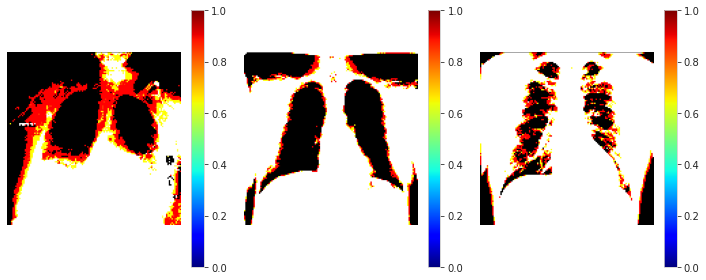

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = X_train[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show();

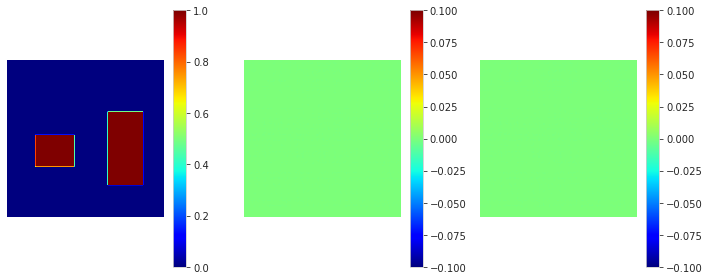

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = mask_train[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show() 

**Creating Models**

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1,1])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (0.025 * focal_loss)
#total_loss = (2*dice_loss*focal_loss)/(dice_loss + focal_loss)
metrics = ["accuracy",sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

input_shape = (128,128,3)

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape = input_shape , n = 2 ,  lr = 0.0001 , loss = total_loss , metrics = metrics ):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    
    resnet50.layers[0]._name  = "input_1"
    
    resnet50._name = "Resnet50"

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           
    s2 = resnet50.get_layer("conv1_relu").output        
    s3 = resnet50.get_layer("conv2_block3_out").output  
    s4 = resnet50.get_layer("conv3_block4_out").output  

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                    
    d2 = decoder_block(d1, s3, 256)                    
    d3 = decoder_block(d2, s2, 128)                   
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = total_loss , metrics = metrics) 
    return model



def build_densenet121_unet(input_shape = input_shape, n = 2 , lr = 0.0001 , loss = total_loss , metrics = metrics ):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet =  tf.keras.applications.DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    densenet.layers[0]._name  = "input_1"
    
    densenet._name = "Densenet121"
    
    """ Encoder """
    s1 = densenet.get_layer("input_1").output       
    s2 = densenet.get_layer("conv1/relu").output   
    s3 = densenet.get_layer("pool2_relu").output 
    s4 = densenet.get_layer("pool3_relu").output  

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)          
    d2 = decoder_block(d1, s3, 256)             
    d3 = decoder_block(d2, s2, 128)            
    d4 = decoder_block(d3, s1, 64)            

    """ Outputs """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = total_loss , metrics = metrics) 
    return model


def build_mobilenetv2_unet(input_shape = input_shape, n = 2 ,  lr = 0.0001 , loss = total_loss , metrics = metrics):   
    """ Input """
    inputs = Input(shape=input_shape)

    """ Pre-trained MobileNetV2 """
    encoder = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",
        input_tensor=inputs)

    encoder.layers[0]._name  = "input_1"
    
    encoder._name = "Mobilenetv2"
    
    """ Encoder """
    s1 = encoder.get_layer("input_1").output               
    s2 = encoder.get_layer("block_1_expand_relu").output    
    s3 = encoder.get_layer("block_3_expand_relu").output   
    s4 = encoder.get_layer("block_6_expand_relu").output   

    """ Bridge """
    b1 = encoder.get_layer("block_13_expand_relu").output  

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                        
    d2 = decoder_block(d1, s3, 256)                        
    d3 = decoder_block(d2, s2, 128)                     
    d4 = decoder_block(d3, s1, 64)                         

    """ Output """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="MobileNetV2_U-Net")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = total_loss , metrics = metrics)  
    return model




model1 = build_resnet50_unet()
model1.summary()

print()
print()
print()
print()


model2 = build_densenet121_unet()
model2.summary()

print()
print()
print()
print()

model3 = build_mobilenetv2_unet()
model3.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNorm





9406464/9406464 [==============================] - 0s 0us/step
Model: "MobileNetV2_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (Re

**Training of the models**
**Using Resnet50 as The encoder**

In [66]:
resnet50 = model1.fit(train, validation_data = val,epochs = 10)

Epoch 1/10
400/400 [==============================] - 84s 210ms/step - loss: 0.0261 - accuracy: 0.9755 - iou_score: 0.9523 - f1-score: 0.9755 - val_loss: 0.0355 - val_accuracy: 0.9661 - val_iou_score: 0.9345 - val_f1-score: 0.9661
Epoch 2/10
400/400 [==============================] - 83s 209ms/step - loss: 0.0223 - accuracy: 0.9789 - iou_score: 0.9588 - f1-score: 0.9789 - val_loss: 0.0320 - val_accuracy: 0.9693 - val_iou_score: 0.9405 - val_f1-score: 0.9693
Epoch 3/10
400/400 [==============================] - 84s 209ms/step - loss: 0.0194 - accuracy: 0.9816 - iou_score: 0.9639 - f1-score: 0.9816 - val_loss: 0.0332 - val_accuracy: 0.9680 - val_iou_score: 0.9381 - val_f1-score: 0.9680
Epoch 4/10
400/400 [==============================] - 83s 208ms/step - loss: 0.0179 - accuracy: 0.9829 - iou_score: 0.9665 - f1-score: 0.9829 - val_loss: 0.0338 - val_accuracy: 0.9674 - val_iou_score: 0.9371 - val_f1-score: 0.9674
Epoch 5/10
400/400 [==============================] - 83s 208ms/step - loss:

**Using Densenet121 as The encoder**

In [ ]:
dense_net = model2.fit(train, validation_data = val, epochs=10)

Epoch 1/10
400/400 [==============================] - 100s 226ms/step - loss: 0.0921 - accuracy: 0.9477 - iou_score: 0.9019 - f1-score: 0.9477 - val_loss: 0.0738 - val_accuracy: 0.9493 - val_iou_score: 0.9039 - val_f1-score: 0.9493
Epoch 2/10
400/400 [==============================] - 88s 219ms/step - loss: 0.0482 - accuracy: 0.9605 - iou_score: 0.9244 - f1-score: 0.9605 - val_loss: 0.0455 - val_accuracy: 0.9609 - val_iou_score: 0.9249 - val_f1-score: 0.9609
Epoch 3/10
400/400 [==============================] - 88s 221ms/step - loss: 0.0401 - accuracy: 0.9651 - iou_score: 0.9328 - f1-score: 0.9651 - val_loss: 0.0412 - val_accuracy: 0.9628 - val_iou_score: 0.9285 - val_f1-score: 0.9628
Epoch 4/10
400/400 [==============================] - 88s 219ms/step - loss: 0.0347 - accuracy: 0.9687 - iou_score: 0.9396 - f1-score: 0.9687 - val_loss: 0.0382 - val_accuracy: 0.9645 - val_iou_score: 0.9317 - val_f1-score: 0.9645
Epoch 5/10
400/400 [==============================] - 87s 218ms/step - loss

# Confusion Matrix for a test Dataset on Densenet121

In [114]:
from sklearn.metrics import confusion_matrix, classification_report
pred_val_3channel = model2.predict(val)

50/50 [==============================] - 6s 121ms/step


In [143]:
y_pred_val = []
for ind, pred_mask in enumerate(pred_val_3channel):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = np.array(pred_mask)
    delme_class = np.max(pred_mask)
    y_pred_val.append(delme_class)


In [145]:
y_pred_val.count(1)

569

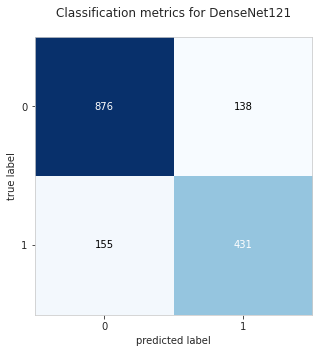

In [147]:
CM = confusion_matrix(y_true_val, y_pred_val)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.title("Classification metrics for DenseNet121")
plt.show()

**Using Mobilenetv2 as The encoder**

In [67]:
mobilenetv2 = model3.fit(train, validation_data = val, epochs=10)

Epoch 1/10
400/400 [==============================] - 79s 180ms/step - loss: 0.1461 - accuracy: 0.8984 - iou_score: 0.8320 - f1-score: 0.8984 - val_loss: 0.0916 - val_accuracy: 0.9525 - val_iou_score: 0.9097 - val_f1-score: 0.9525
Epoch 2/10
400/400 [==============================] - 70s 175ms/step - loss: 0.0576 - accuracy: 0.9595 - iou_score: 0.9225 - f1-score: 0.9595 - val_loss: 0.0566 - val_accuracy: 0.9549 - val_iou_score: 0.9140 - val_f1-score: 0.9549
Epoch 3/10
400/400 [==============================] - 70s 175ms/step - loss: 0.0444 - accuracy: 0.9642 - iou_score: 0.9311 - f1-score: 0.9642 - val_loss: 0.0468 - val_accuracy: 0.9596 - val_iou_score: 0.9226 - val_f1-score: 0.9596
Epoch 4/10
400/400 [==============================] - 71s 177ms/step - loss: 0.0366 - accuracy: 0.9686 - iou_score: 0.9393 - f1-score: 0.9686 - val_loss: 0.0442 - val_accuracy: 0.9601 - val_iou_score: 0.9236 - val_f1-score: 0.9601
Epoch 5/10
400/400 [==============================] - 70s 175ms/step - loss:

In [ ]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Step 4: Pickle the model for future prediction

**Observation:**
According to the above performance metrics **densenet** is giving the highest validation accuracy so we'll pickle the model. 

In [ ]:
# pickling densenet
pickle.dump(model2, open('DenseNet.pkl','wb'))


In [ ]:
# pickling resnet
pickle.dump(model1, open('ResNet.pkl','wb'))


In [ ]:
# pickling mobilenet
pickle.dump(model3, open('mobileNet.pkl','wb'))


**Evaluation**

In [ ]:
def plot(r):

    plt.figure(figsize=(12, 16))

    plt.subplot(4, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy Function Evolution')
    plt.legend()

    plt.subplot(4, 2, 3)
    plt.plot(r.history['iou_score'], label='iou_score')
    plt.plot(r.history['val_iou_score'], label='val_iou_score')
    plt.title('Iou score Evolution')
    plt.legend()

    plt.subplot(4, 2, 4)
    plt.plot(r.history['f1-score'], label='f1-score')
    plt.plot(r.history['val_f1-score'], label='val_f1-score')
    plt.title('f1-score Evolution')
    plt.legend()

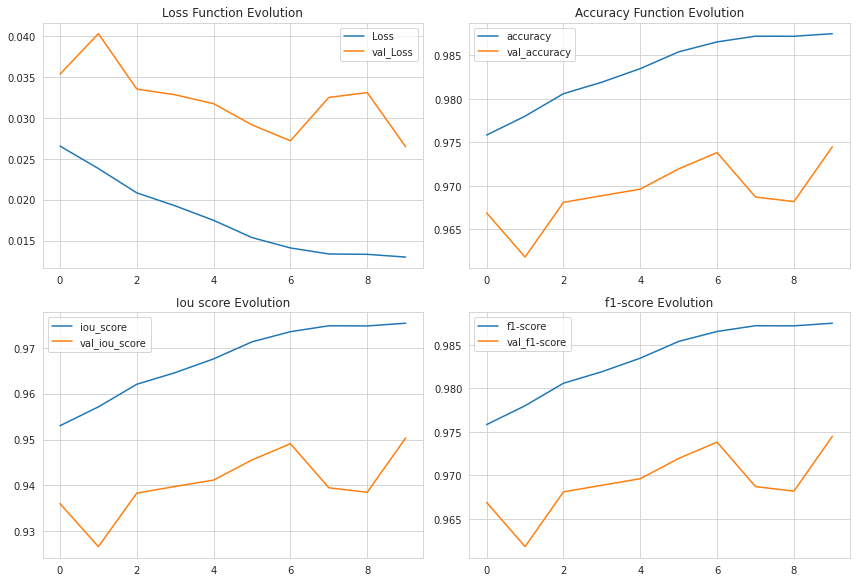

In [ ]:
#Resnet50 Encoder Metrics
plot(resnet50)

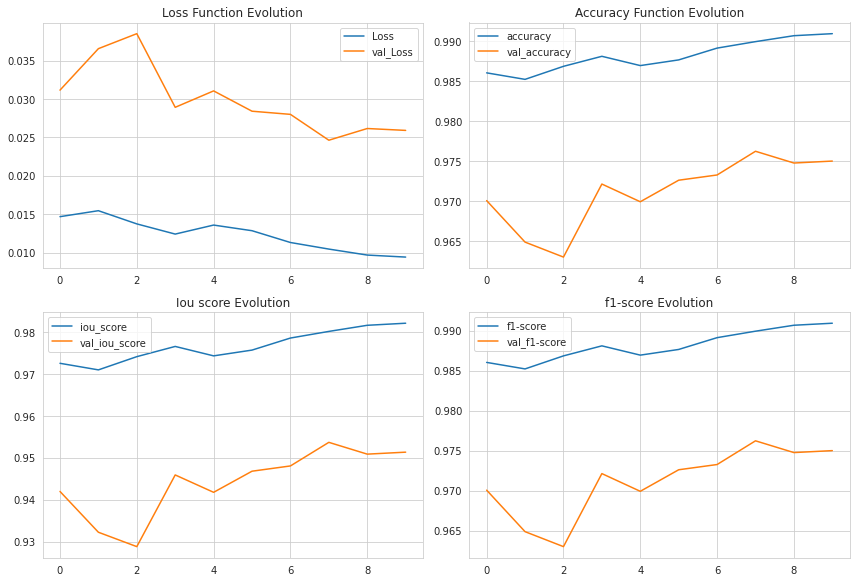

In [ ]:
#Densenet121 Encoder Metrics
plot(dense_net)

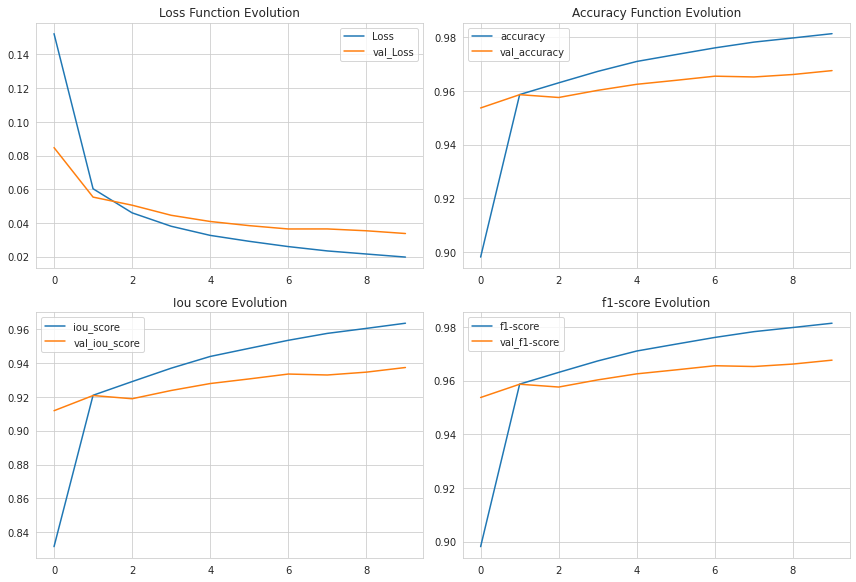

In [ ]:
#Densenet121 Encoder Metrics
plot(mobilenetv2)

In [86]:
def create_mask1(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(X,y, model ):

    pred_mask = model.predict(X)
    
    display([X, y, create_mask1(pred_mask)])



def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
  
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if(i == 0):
      plt.imshow(tf.keras.utils.array_to_img(display_list[i][0]))
    else:  
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

1/1 [==============================] - 1s 1s/step


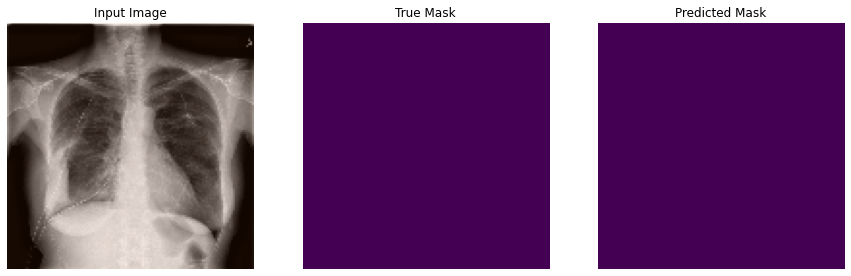

1/1 [==============================] - 0s 24ms/step


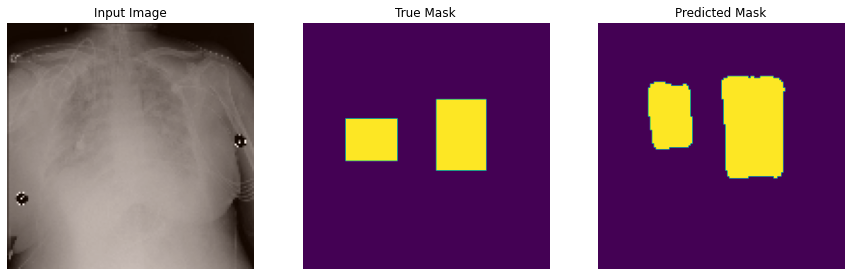

1/1 [==============================] - 0s 24ms/step


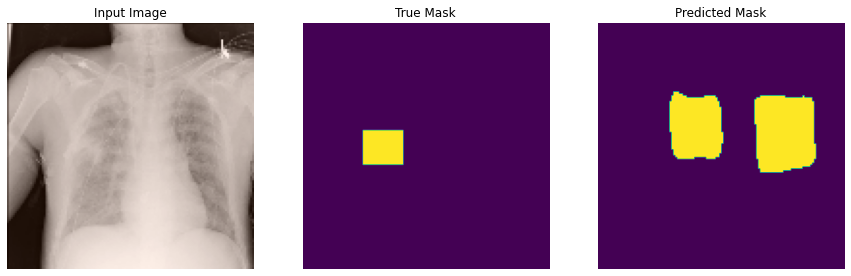

1/1 [==============================] - 0s 24ms/step


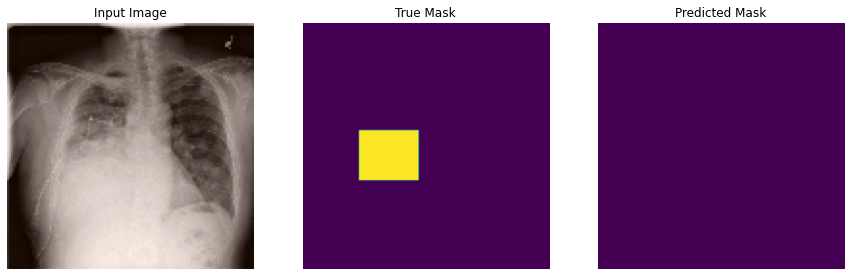

1/1 [==============================] - 0s 24ms/step


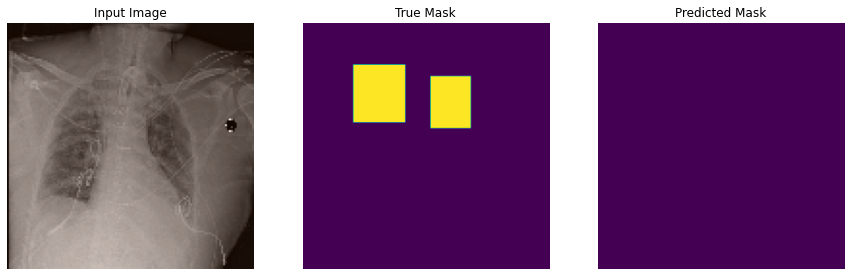

1/1 [==============================] - 0s 24ms/step


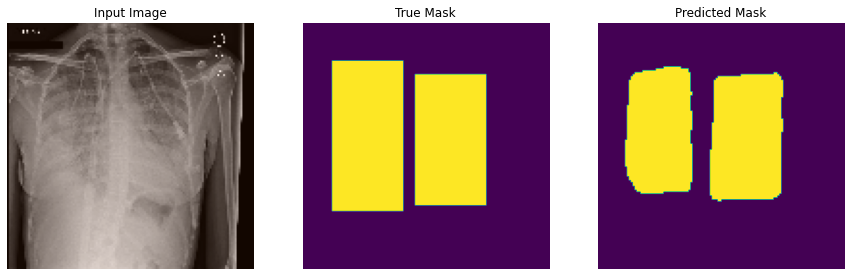

1/1 [==============================] - 0s 24ms/step


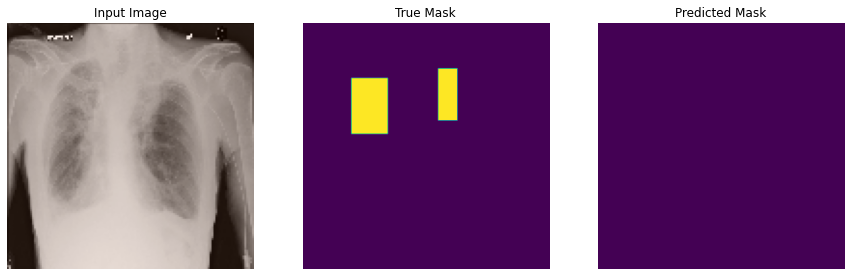

1/1 [==============================] - 0s 26ms/step


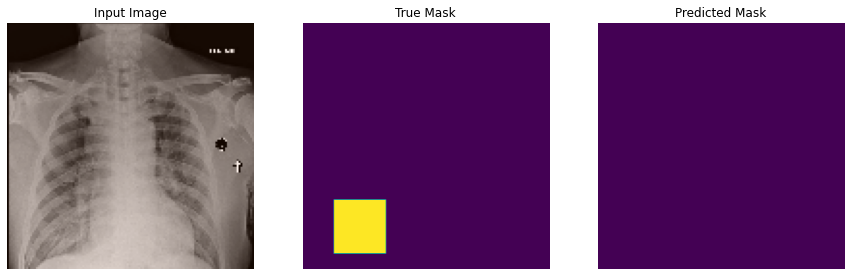

1/1 [==============================] - 0s 26ms/step


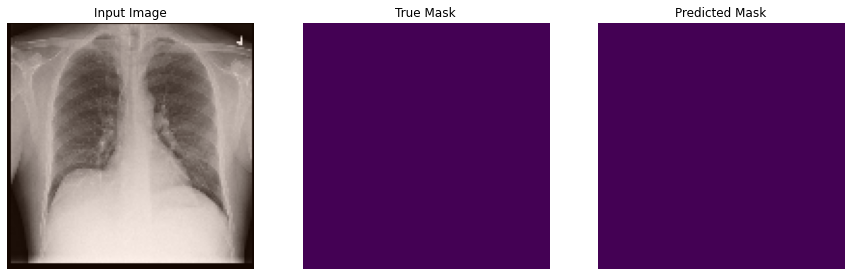

1/1 [==============================] - 0s 26ms/step


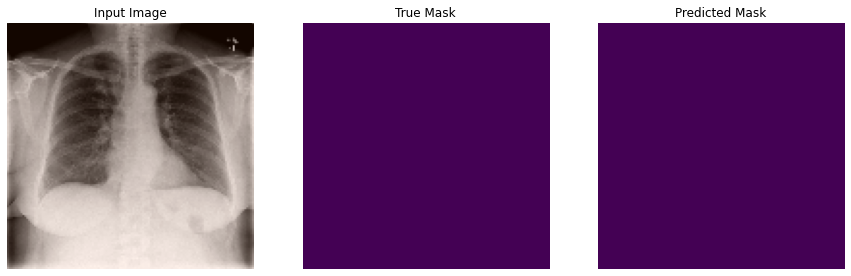

In [ ]:
#Visualization Resnet50 Encoder
for i in range(0,10):
    show_predictions(X_val[i:i+1] , mask_val[i].reshape(128,128,1),model1)

1/1 [==============================] - 2s 2s/step


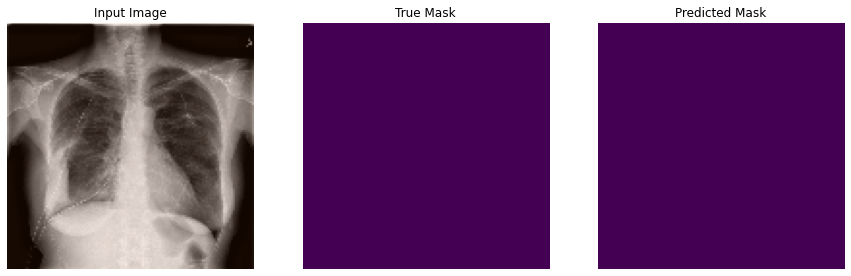

1/1 [==============================] - 0s 31ms/step


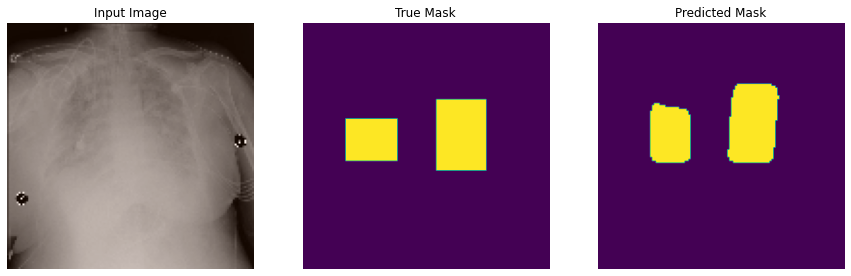

1/1 [==============================] - 0s 36ms/step


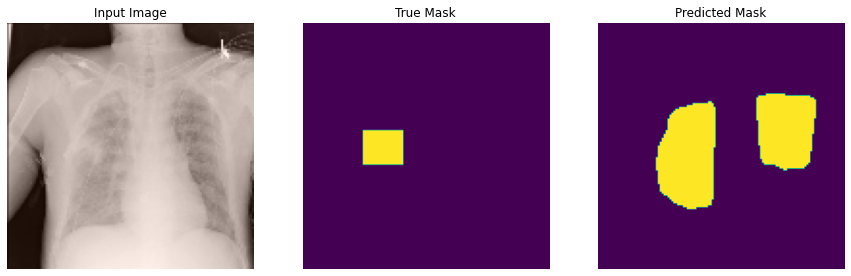

1/1 [==============================] - 0s 32ms/step


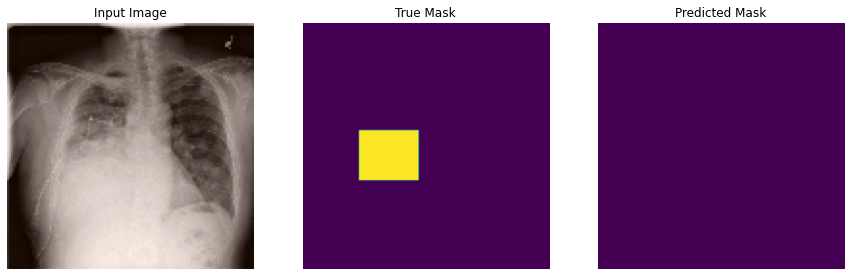

1/1 [==============================] - 0s 33ms/step


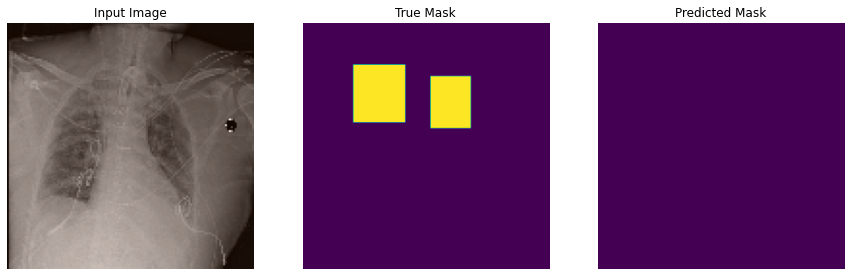

1/1 [==============================] - 0s 33ms/step


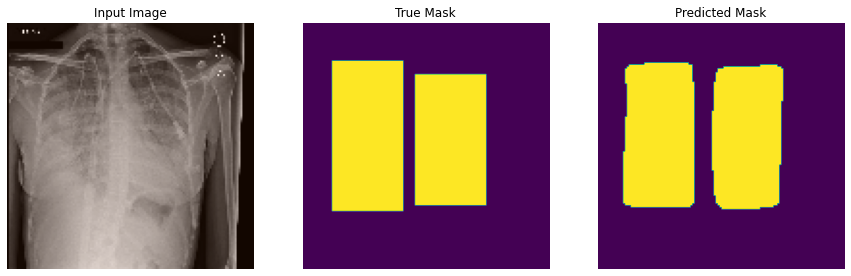

1/1 [==============================] - 0s 30ms/step


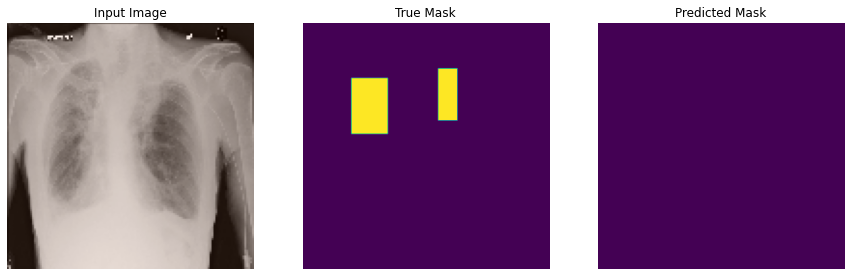

1/1 [==============================] - 0s 31ms/step


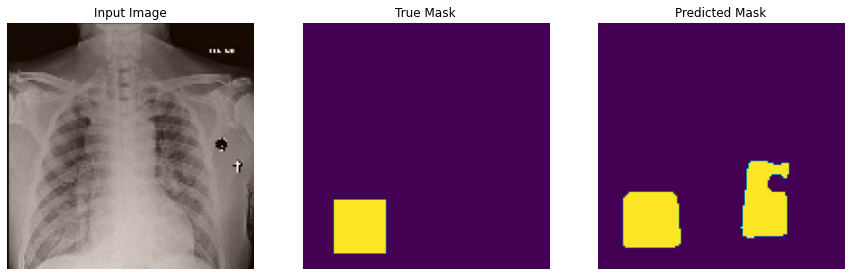

1/1 [==============================] - 0s 32ms/step


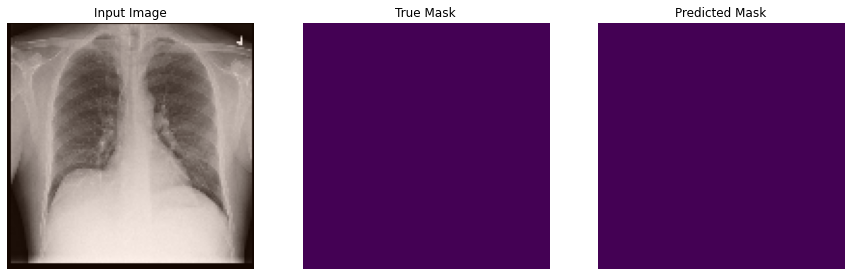

1/1 [==============================] - 0s 31ms/step


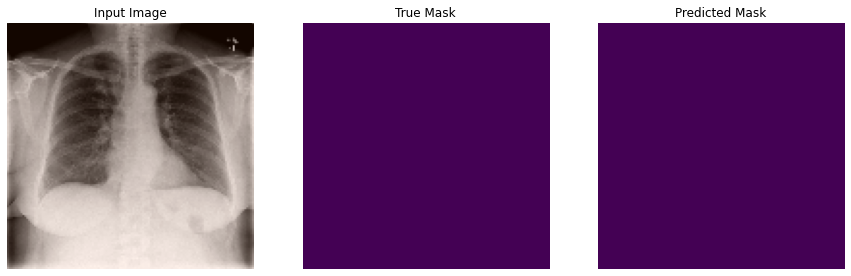

In [ ]:
#Visualization Densenet121 Encoder
for i in range(0,10):
    show_predictions(X_val[i:i+1] , mask_val[i].reshape(128,128,1),model2)

1/1 [==============================] - 0s 26ms/step


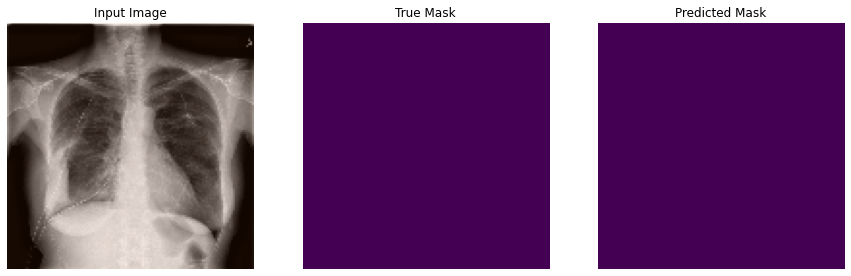

1/1 [==============================] - 0s 23ms/step


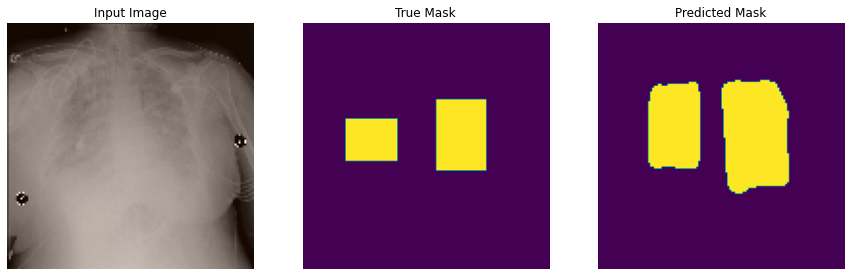

1/1 [==============================] - 0s 25ms/step


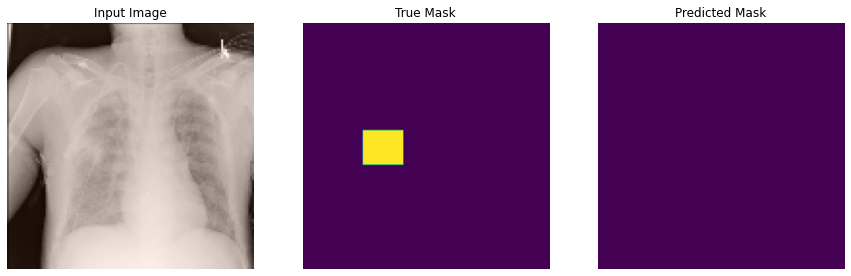

1/1 [==============================] - 0s 24ms/step


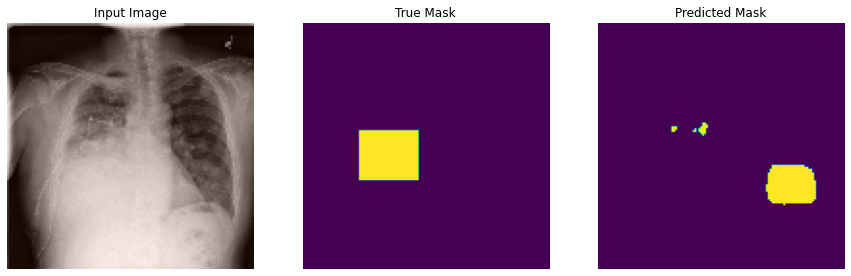

1/1 [==============================] - 0s 24ms/step


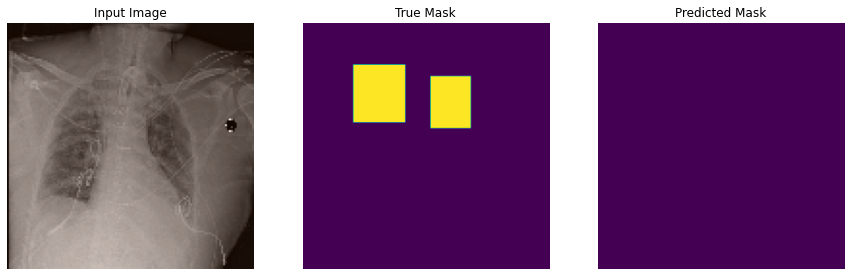

1/1 [==============================] - 0s 25ms/step


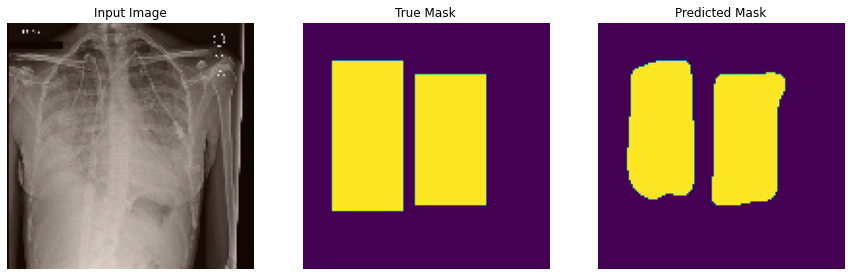

1/1 [==============================] - 0s 22ms/step


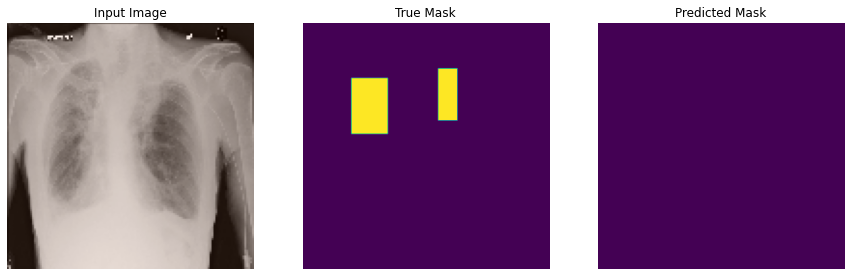

1/1 [==============================] - 0s 24ms/step


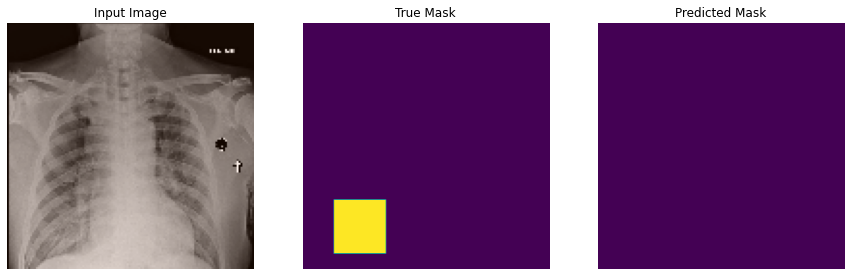

1/1 [==============================] - 0s 23ms/step


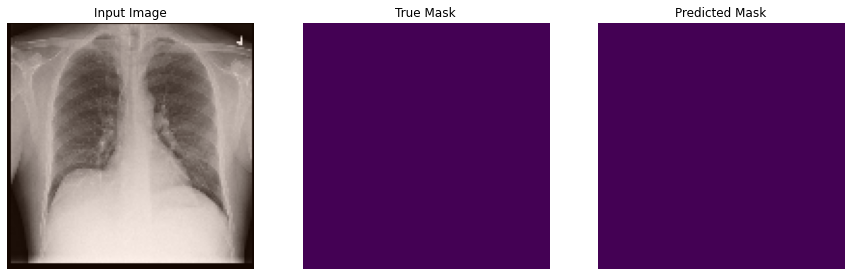

1/1 [==============================] - 0s 24ms/step


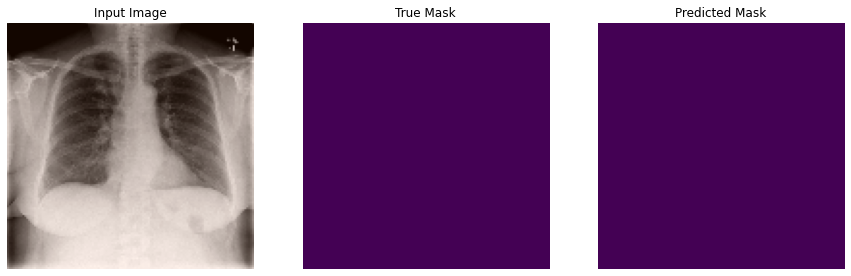

In [ ]:
#Visualization Mobilenetv2 Encoder
for i in range(0,10):
    show_predictions(X_val[i:i+1] , mask_val[i].reshape(128,128,1),model3)

In [ ]:
#Mean Iou Scores
def pred(X,y,model,num):
  #returns the y preds and y accutual 

  y_acc = []
  y_pred = []
  for i in range(0,num):
    y_acc.append(y[i].reshape(128,128,1))
    y_pred.append(create_mask1(model.predict(X[i:i+1] , verbose = 0 )) )

  y_acc = np.array(y_acc)  
  y_pred = np.array(y_pred)

  return (y_acc,y_pred)


def mean_iou_score(model,X_val,y_val,n_classes = 2 ):
  y_acc , y_pred = pred(X_val,y_val,model , len(y_val))
  IOU_ref = MeanIoU(num_classes=n_classes)
  IOU_ref.update_state(y_acc , y_pred)

  print("Mean iou score ", IOU_ref.result().numpy())


In [ ]:
#Mean IOU Score on Resnet50
mean_iou_score(model1,X_val,mask_val)

Mean iou score  0.7751684


In [ ]:
#Mean IOU Score on Densenet121
mean_iou_score(model2,X_val,mask_val)

Mean iou score  0.7828642


In [ ]:
#Mean IOU Score on Mobilenetv2
mean_iou_score(model3,X_val,mask_val)

Mean iou score  0.7128465
